In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bioframe
from hmmlearn import hmm
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Read 4C data and TetO coordinates

In [2]:
teto_coordinates = pd.read_csv('C17_TetO_locations_manual_TACL_domains.txt', sep = '\t')
teto_coordinates.head()

chrom      start        end  teto_id  domain_small_start  domain_small_end  \
0   chr3   33400162   33400162        1            32943025          33896603   
1  chr17   19456127   19456127        2            19355266          20333029   
2   chr1  237830986  237830986        3           237543776         240050358   
3  chr18   47931745   47931745        4            47083150          48559650   
4   chr8   65550156   65550156        5            64245069          66639209   

   domain_large_start  domain_large_end  
0            29979716          37412478  
1            17348282          22822656  
2           233321503         242063930  
3            43557896          51704212  
4            61012154          69728571

In [3]:
tacl_domains = pd.read_csv('TACL_domains_HMM.bed', sep = '\t', header = None)
tacl_domains.columns = ['chrom', 'start', 'end', 'teto_id']
tacl_domains.head()

chrom      start        end  teto_id
0   chr3   32710370   34267172        1
1  chr17   19348155   21034668        2
2   chr1  237514789  239990427        3
3  chr18   46949582   48492721        4
4   chr8   64261002   66451818        5

In [4]:
vp_data_merged = pd.read_csv('4C_data_degrons_domains_HMM.txt', sep = '\t')
vp_data_merged

chrom     start       end      ctcf_unt    ctcf_iaa3h    ctcf_dox3h  \
0       chr3  23399791  23400411  2.747328e+00  6.768890e+00  9.790857e-01   
1       chr3  23400574  23400660  2.518384e+00  6.204816e+00  8.974953e-01   
2       chr3  23400871  23401212  2.324662e+00  5.727522e+00  3.313829e+00   
3       chr3  23402320  23402344  2.158615e+00  5.318413e+00  3.077127e+00   
4       chr3  23402464  23402607  2.014707e+00  4.963853e+00  2.871985e+00   
...      ...       ...       ...           ...           ...           ...   
786862  chr5  44367977  44368490 -8.147557e-14 -8.644937e-15  1.143974e-13   
786863  chr5  44368626  44368772 -8.729525e-14 -9.262432e-15  1.225686e-13   
786864  chr5  44370418  44370843 -9.401027e-14 -9.974927e-15  1.319970e-13   
786865  chr5  44372335  44372650 -1.018445e-13 -1.080617e-14  1.429967e-13   
786866  chr5  44372647  44372944 -1.111030e-13 -1.178855e-14  1.559964e-13   

           pds5a_unt  pds5a_iaa3h   pds5a_dox3h  stag2_unt   stag2_iaa1h  \
0       1.819110e+00     7.247666  1.610735e+00   3.466604  3.746048e+00   
1       2.501276e+00     6.643694  1.476507e+00   3.177720  3.433877e+00   
2       4.617740e+00     8.858259  1.362930e+00   2.933280  3.169733e+00   
3       4.287901e+00     8.225526  1.265578e+00   2.723760  2.943323e+00   
4       4.002041e+00     7.677158  1.181206e+00   2.542176  2.747102e+00   
...              ...          ...           ...        ...           ...   
786862  1.615300e-13     4.673279 -1.440033e-13   0.985450  1.610564e-13   
786863  1.730679e-13     5.007085 -1.542893e-13   1.055839  1.725604e-13   
786864  1.863808e-13     5.392245 -1.661577e-13   1.137057  1.858343e-13   
786865  2.019126e-13     5.841599 -1.800042e-13   1.231812  2.013204e-13   
786866  2.202682e-13     6.372654 -1.963682e-13   1.343795  2.196223e-13   

         stag2_dox3h   wapl_unt  wapl_iaa3h  wapl_dox3h  teto_id         mid  
0       7.669631e+00   6.768451    0.666416    5.198710        1  23400101.0  
1       7.030495e+00   6.204413    0.610881    4.765484        1  23400617.0  
2       8.112109e+00   5.727151    0.563890    4.398908        1  23401041.5  
3       7.532673e+00   5.318068    0.523612    4.084700        1  23402332.0  
4       7.030495e+00   4.963530    0.488705    3.812387        1  23402535.5  
...              ...        ...         ...         ...      ...         ...  
786862 -9.426534e-14  19.498879   24.420024    0.000000       27  44368233.5  
786863 -1.009986e-13  20.891656   26.164312    0.000000       27  44368699.0  
786864 -1.087677e-13  22.498706   28.176951    0.000000       27  44370630.5  
786865 -1.178317e-13  24.373599   30.525031    0.000000       27  44372492.5  
786866 -1.285436e-13  26.589380   33.300033    0.000000       27  44372795.5  

[786867 rows x 17 columns]

## Define HMM model parameters and filter parameters

In [10]:
# Set HMM parameters
cutoff = 25
print('Delta signal cutoff:', cutoff)

prob_tacl_domain = 0.60
prob_no_domain = 0.02
emission_matrix = np.array([[prob_tacl_domain, 1-prob_tacl_domain],
                            [prob_no_domain, 1-prob_no_domain]])
print('\nEmission matrix:\n', emission_matrix)

transition = 0.000001
transition_matrix = np.array([[1-transition, transition],
                              [transition, 1-transition]])
print('\nTransition matrix:\n', transition_matrix)

consecutive_threshold = 20
print('\nConsecutive HMM calls threshold:', consecutive_threshold)

merge_distance_restriction_fragments = 200000
number_restriction_fragments = 40
merge_distance_hmm_domains = 2500000
print('\nMerge distance clustering restriction fragments :', merge_distance_restriction_fragments)
print('Minimal number of restriction fragments to keep clusters:', number_restriction_fragments)
print('Merge distance calling domains:', merge_distance_hmm_domains)

Delta signal cutoff: 25

Emission matrix:
 [[0.6  0.4 ]
 [0.02 0.98]]

Transition matrix:
 [[9.99999e-01 1.00000e-06]
 [1.00000e-06 9.99999e-01]]

Consecutive HMM calls threshold: 20

Merge distance clustering restriction fragments : 200000
Minimal number of restriction fragments to keep clusters: 40
Merge distance calling domains: 2500000


In [11]:
# Define HMM model for calling TACL domains
tacl_domains_model = hmm.CategoricalHMM(n_components = 2, random_state = 99, init_params = '')

# Initialise with estimated parameters
tacl_domains_model.transmat_ = transition_matrix
tacl_domains_model.emissionprob_ = emission_matrix
tacl_domains_model.startprob_ = np.array([1.0, 0.0])
tacl_domains_model

CategoricalHMM(init_params='', n_components=2, random_state=99)

## Call HMM states for each cell line

In [12]:
# Call domain states for all viewpoints
def get_binary_observations_relative(condition1, condition2, viewpoint_id, cutoff):
    observations = vp_data_merged[vp_data_merged['teto_id'] == viewpoint_id]
    deltas = observations[condition1] - observations[condition2]
    binary_deltas = [[1] if d > cutoff else [0] for d in deltas]
    return(binary_deltas)

def calculate_hmm_states(condition1, condition2, cutoff, failed_viewpoints = []):
    hmm_states_tacl_domains = []
    for viewpoint_id_hmm in range(1, 28):
        binary_signal_difference = get_binary_observations_relative(condition1, condition2, viewpoint_id_hmm, cutoff)
        if viewpoint_id_hmm in failed_viewpoints:
            hmm_states_tacl_domains = hmm_states_tacl_domains + list([np.nan]*len(binary_signal_difference))
        else:
            tacl_domains_model.fit(binary_signal_difference)
            hmm_results = tacl_domains_model.predict(binary_signal_difference)
            hmm_states_tacl_domains = hmm_states_tacl_domains + list(hmm_results)
    return(hmm_states_tacl_domains)

# Keep restriction fragments within consecutive HMM state calls
def calculate_intervals_from_range(list_range):
    list_range = list(list_range)
    intervals = []
    for idx, item in enumerate(list_range):
        if not idx or item-1 != intervals[-1][-1]:
            intervals.append([item])
        else:
            intervals[-1].append(item)
    return(intervals)

def calculate_confident_hmm_states(hmm_data, hmm_state_calls):
    hmm_state_intervals = calculate_intervals_from_range(hmm_data[hmm_data[hmm_state_calls] == 1].index)
    hmm_state_intervals_confident = [x for x in hmm_state_intervals if len(x) >= consecutive_threshold]
    hmm_state_intervals_confident = [item for items in hmm_state_intervals_confident for item in items]
    hmm_state_intervals_confident = np.unique(hmm_state_intervals_confident)
    hmm_states_tacl_domains_confident = [1 if x in hmm_state_intervals_confident else 0 for x in np.arange(len(hmm_data))]
    return(hmm_states_tacl_domains_confident)

In [13]:
vp_data_merged['hmm_state_ctcf'] = calculate_hmm_states('ctcf_iaa3h', 'ctcf_dox3h', cutoff)
vp_data_merged['hmm_state_wapl'] = calculate_hmm_states('wapl_iaa3h', 'wapl_dox3h', cutoff, failed_viewpoints = [6, 8, 25, 27])
vp_data_merged['hmm_state_stag2'] = calculate_hmm_states('stag2_iaa1h', 'stag2_dox3h', cutoff)
vp_data_merged['hmm_state_pds5a'] = calculate_hmm_states('pds5a_iaa3h', 'pds5a_dox3h', cutoff)
vp_data_merged

chrom     start       end      ctcf_unt    ctcf_iaa3h    ctcf_dox3h  \
0       chr3  23399791  23400411  2.747328e+00  6.768890e+00  9.790857e-01   
1       chr3  23400574  23400660  2.518384e+00  6.204816e+00  8.974953e-01   
2       chr3  23400871  23401212  2.324662e+00  5.727522e+00  3.313829e+00   
3       chr3  23402320  23402344  2.158615e+00  5.318413e+00  3.077127e+00   
4       chr3  23402464  23402607  2.014707e+00  4.963853e+00  2.871985e+00   
...      ...       ...       ...           ...           ...           ...   
786862  chr5  44367977  44368490 -8.147557e-14 -8.644937e-15  1.143974e-13   
786863  chr5  44368626  44368772 -8.729525e-14 -9.262432e-15  1.225686e-13   
786864  chr5  44370418  44370843 -9.401027e-14 -9.974927e-15  1.319970e-13   
786865  chr5  44372335  44372650 -1.018445e-13 -1.080617e-14  1.429967e-13   
786866  chr5  44372647  44372944 -1.111030e-13 -1.178855e-14  1.559964e-13   

           pds5a_unt  pds5a_iaa3h   pds5a_dox3h  stag2_unt  ...  wapl_iaa3h  \
0       1.819110e+00     7.247666  1.610735e+00   3.466604  ...    0.666416   
1       2.501276e+00     6.643694  1.476507e+00   3.177720  ...    0.610881   
2       4.617740e+00     8.858259  1.362930e+00   2.933280  ...    0.563890   
3       4.287901e+00     8.225526  1.265578e+00   2.723760  ...    0.523612   
4       4.002041e+00     7.677158  1.181206e+00   2.542176  ...    0.488705   
...              ...          ...           ...        ...  ...         ...   
786862  1.615300e-13     4.673279 -1.440033e-13   0.985450  ...   24.420024   
786863  1.730679e-13     5.007085 -1.542893e-13   1.055839  ...   26.164312   
786864  1.863808e-13     5.392245 -1.661577e-13   1.137057  ...   28.176951   
786865  2.019126e-13     5.841599 -1.800042e-13   1.231812  ...   30.525031   
786866  2.202682e-13     6.372654 -1.963682e-13   1.343795  ...   33.300033   

        wapl_dox3h  teto_id         mid  hmm_state_ctcf  hmm_state_wapl  \
0         5.198710        1  23400101.0               0             0.0   
1         4.765484        1  23400617.0               0             0.0   
2         4.398908        1  23401041.5               0             0.0   
3         4.084700        1  23402332.0               0             0.0   
4         3.812387        1  23402535.5               0             0.0   
...            ...      ...         ...             ...             ...   
786862    0.000000       27  44368233.5               0             NaN   
786863    0.000000       27  44368699.0               0             NaN   
786864    0.000000       27  44370630.5               0             NaN   
786865    0.000000       27  44372492.5               0             NaN   
786866    0.000000       27  44372795.5               0             NaN   

        hmm_state_stag2  hmm_state_pds5a  hmm_state_ctcf_confident  \
0                     0                0                         0   
1                     0                0                         0   
2                     0                0                         0   
3                     0                0                         0   
4                     0                0                         0   
...                 ...              ...                       ...   
786862                0                0                         0   
786863                0                0                         0   
786864                0                0                         0   
786865                0                0                         0   
786866                0                0                         0   

        hmm_state_wapl_confident  
0                              0  
1                              0  
2                              0  
3                              0  
4                              0  
...                          ...  
786862                         0  
786863                         0  
786864                         0  
786865                       

In [14]:
vp_data_merged['hmm_state_ctcf_confident'] = calculate_confident_hmm_states(vp_data_merged, 'hmm_state_ctcf')
vp_data_merged['hmm_state_wapl_confident'] = calculate_confident_hmm_states(vp_data_merged, 'hmm_state_wapl')
vp_data_merged['hmm_state_stag2_confident'] = calculate_confident_hmm_states(vp_data_merged, 'hmm_state_stag2')
vp_data_merged['hmm_state_pds5a_confident'] = calculate_confident_hmm_states(vp_data_merged, 'hmm_state_pds5a')
vp_data_merged

chrom     start       end      ctcf_unt    ctcf_iaa3h    ctcf_dox3h  \
0       chr3  23399791  23400411  2.747328e+00  6.768890e+00  9.790857e-01   
1       chr3  23400574  23400660  2.518384e+00  6.204816e+00  8.974953e-01   
2       chr3  23400871  23401212  2.324662e+00  5.727522e+00  3.313829e+00   
3       chr3  23402320  23402344  2.158615e+00  5.318413e+00  3.077127e+00   
4       chr3  23402464  23402607  2.014707e+00  4.963853e+00  2.871985e+00   
...      ...       ...       ...           ...           ...           ...   
786862  chr5  44367977  44368490 -8.147557e-14 -8.644937e-15  1.143974e-13   
786863  chr5  44368626  44368772 -8.729525e-14 -9.262432e-15  1.225686e-13   
786864  chr5  44370418  44370843 -9.401027e-14 -9.974927e-15  1.319970e-13   
786865  chr5  44372335  44372650 -1.018445e-13 -1.080617e-14  1.429967e-13   
786866  chr5  44372647  44372944 -1.111030e-13 -1.178855e-14  1.559964e-13   

           pds5a_unt  pds5a_iaa3h   pds5a_dox3h  stag2_unt  ...  teto_id  \
0       1.819110e+00     7.247666  1.610735e+00   3.466604  ...        1   
1       2.501276e+00     6.643694  1.476507e+00   3.177720  ...        1   
2       4.617740e+00     8.858259  1.362930e+00   2.933280  ...        1   
3       4.287901e+00     8.225526  1.265578e+00   2.723760  ...        1   
4       4.002041e+00     7.677158  1.181206e+00   2.542176  ...        1   
...              ...          ...           ...        ...  ...      ...   
786862  1.615300e-13     4.673279 -1.440033e-13   0.985450  ...       27   
786863  1.730679e-13     5.007085 -1.542893e-13   1.055839  ...       27   
786864  1.863808e-13     5.392245 -1.661577e-13   1.137057  ...       27   
786865  2.019126e-13     5.841599 -1.800042e-13   1.231812  ...       27   
786866  2.202682e-13     6.372654 -1.963682e-13   1.343795  ...       27   

               mid  hmm_state_ctcf  hmm_state_wapl  hmm_state_stag2  \
0       23400101.0               0             0.0                0   
1       23400617.0               0             0.0                0   
2       23401041.5               0             0.0                0   
3       23402332.0               0             0.0                0   
4       23402535.5               0             0.0                0   
...            ...             ...             ...              ...   
786862  44368233.5               0             NaN                0   
786863  44368699.0               0             NaN                0   
786864  44370630.5               0             NaN                0   
786865  44372492.5               0             NaN                0   
786866  44372795.5               0             NaN                0   

        hmm_state_pds5a  hmm_state_ctcf_confident  hmm_state_wapl_confident  \
0                     0                         0                         0   
1                     0                         0                         0   
2                     0                         0                         0   
3                     0                         0                         0   
4                     0                         0                         0   
...                 ...                       ...                       ...   
786862                0                         0                         0   
786863                0                         0                         0   
786864                0                         0                         0   
786865                0                         0                         0   
786866                0                         0                         0   

        hmm_state_stag2_confident  hmm_state_pds5a_confident  
0                               0                          0  
1                               0                          0  
2                               0                          0  
3                               0                          0  
4                               0       

## Define TACL domains

In [15]:
# Define TACL domains by stitching together consecutive regions with the same state
def find_tacl_domains(hmm_data, hmm_state_confident_calls, teto_coordinates, failed_viewpoints = []):
    tacl_domain_start, tacl_domain_end = [], []
    for viewpoint_id_hmm in range(1, 28):
        if viewpoint_id_hmm in failed_viewpoints:
            tacl_domain_start.append(np.nan)
            tacl_domain_end.append(np.nan)
        else:
            vp_hmm_results = hmm_data[hmm_data['teto_id'] == viewpoint_id_hmm]

            # Merge restriction fragments from TACL domain state within 100kb from each other
            draft_tacl_domain_small = bioframe.merge(vp_hmm_results[vp_hmm_results[hmm_state_confident_calls] == 1], 
                                                     min_dist = merge_distance_restriction_fragments)
            # Retain merged regions with at least 40 restriction fragments and further merge them within 2.5Mb distance
            draft_tacl_domain_large = bioframe.merge(draft_tacl_domain_small[draft_tacl_domain_small['n_intervals'] >= number_restriction_fragments], 
                                                     min_dist = merge_distance_hmm_domains)

            # Overlap with TetO coordinates to avoid confusion when two platforms are close to each other
            called_tacl_domain = bioframe.overlap(draft_tacl_domain_large, teto_coordinates[teto_coordinates['teto_id'] == viewpoint_id_hmm]).dropna()
            # If TetO is outside of called TACL domain, find nearest domains on both sides and stitch them to include TetO
            if len(called_tacl_domain) == 0:
                closest_small_tacl_domains = bioframe.closest(draft_tacl_domain_small, teto_coordinates[teto_coordinates['teto_id'] == viewpoint_id_hmm], suffixes=('', '_teto'))
                closest_small_tacl_domains['abs_distance'] = (closest_small_tacl_domains['start'] + closest_small_tacl_domains['end'])/2 - closest_small_tacl_domains['start_teto']
                closest_right = closest_small_tacl_domains[closest_small_tacl_domains['abs_distance']>0].sort_values('distance').values[0][:4]
                closest_left = closest_small_tacl_domains[closest_small_tacl_domains['abs_distance']<0].sort_values('distance').values[0][:4]

                draft_tacl_domain_large_extended = (pd.DataFrame(list(draft_tacl_domain_large.values) + [list(closest_right), list(closest_left)]))
                draft_tacl_domain_large_extended.columns = ['chrom', 'start', 'end', 'n_intervals']
                draft_tacl_domain_large_extended = bioframe.merge(draft_tacl_domain_large_extended, min_dist = 2500000)
                called_tacl_domain = bioframe.overlap(draft_tacl_domain_large_extended, teto_coordinates[teto_coordinates['teto_id'] == viewpoint_id_hmm]).dropna()
            else:
                pass
            tacl_domain_start.append(called_tacl_domain.values[0][1])
            tacl_domain_end.append(called_tacl_domain.values[0][2])
    return([tacl_domain_start, tacl_domain_end])

In [16]:
tacl_domains_ctcf = find_tacl_domains(vp_data_merged, 'hmm_state_ctcf_confident', teto_coordinates)
tacl_domains_wapl = find_tacl_domains(vp_data_merged, 'hmm_state_wapl_confident', teto_coordinates, failed_viewpoints = [6, 8, 25, 27])
tacl_domains_stag2 = find_tacl_domains(vp_data_merged, 'hmm_state_stag2_confident', teto_coordinates)
tacl_domains_pds5a = find_tacl_domains(vp_data_merged, 'hmm_state_pds5a_confident', teto_coordinates)

In [22]:
tacl_domains['tacl_domain_ctcf_start'] = tacl_domains_ctcf[0]
tacl_domains['tacl_domain_ctcf_end'] = tacl_domains_ctcf[1]
tacl_domains['tacl_domain_wapl_start'] = tacl_domains_wapl[0]
tacl_domains['tacl_domain_wapl_end'] = tacl_domains_wapl[1]
tacl_domains['tacl_domain_stag2_start'] = tacl_domains_stag2[0]
tacl_domains['tacl_domain_stag2_end'] = tacl_domains_stag2[1]
tacl_domains['tacl_domain_pds5a_start'] = tacl_domains_pds5a[0]
tacl_domains['tacl_domain_pds5a_end'] = tacl_domains_pds5a[1]
tacl_domains

chrom      start        end  teto_id  tacl_domain_ctcf_start  \
0    chr3   32710370   34267172        1                31524002   
1   chr17   19348155   21034668        2                18370793   
2    chr1  237514789  239990427        3               236081665   
3   chr18   46949582   48492721        4                47243931   
4    chr8   64261002   66451818        5                63388956   
5    chrX  131792264  133688381        6               130766932   
6   chr15   56391142   58292274        7                55171860   
7   chr18   55225594   57174399        8                55795547   
8   chr13   61946766   65660533        9                60030569   
9    chr3   52839308   56309637       10                51932104   
10   chr9   33029718   35017875       11                31096594   
11  chr10   60428007   63773965       12                59580465   
12  chr11   94593974   97202372       13                93655848   
13   chr7   75421996   76507403       14                74564667   
14   chr8  114152551  117061146       15               112792466   
15   chr5  128193307  130692301       16               126327887   
16   chr4  109981030  112067813       17               108013169   
17  chr18   74541535   77045026       18                72589275   
18   chr4  109981030  112067813       19               110615049   
19  chr20   50973223   53969861       20                49977468   
20   chr6   63917202   68349334       21                63698681   
21  chr19   27750204   31444954       22                27446002   
22  chr16   58801619   62142926       23                57461684   
23  chr10  125374115  128161719       24               123897938   
24  chr17   42017995   43347297       25                41960030   
25   chr2   50473017   53833247       26                48767658   
26   chr5   32608348   35961615       27                32087103   

    tacl_domain_ctcf_end  tacl_domain_wapl_start  tacl_domain_wapl_end  \
0               35748833              30689949.0            37036534.0   
1               22316950              17344811.0            22685229.0   
2              239984499             235499255.0           240953328.0   
3               49650932              45612014.0            50460939.0   
4               66876298              61554095.0            69652803.0   
5              134423586                     NaN                   NaN   
6               58899380              53801716.0            59539917.0   
7               57400287                     NaN                   NaN   
8               67239871              59322625.0            67246629.0   
9               56201664              51994282.0            57179719.0   
10              35769607              31130514.0            35661229.0   
11              64130161              58776166.0            64104760.0   
12              99024112              93880154.0           101445464.0   
13              78388233              73652968.0            80060730.0   
14             117632058             111417920.0           119452722.0   
15             131024447             126317871.0           132195765.0   
16             114702552             107030771.0           114391220.0   
17              79041116              72535532.0            79537393.0   
18             114702552             107030771.0           114391220.0   
19              54887851              49324947.0            54687395.0   
20              70221933              62146799.0            70380305.0   
21              32245614              27954723.0            32700910.0   
22              61390387              57301506.0            63465497.0   
23             128579457             123523550.0           130011009.0   
24              43380908                     NaN                   NaN   
25              54654180              48583216.0            56190430.0   
26              35987938                     NaN                   NaN   

    tacl_domain_stag2_star

In [23]:
tacl_domains.to_csv('degrons_domains_HMM.txt', sep = '\t', header = 1, index = 0)

### Statistics TACL domains degrons

In [136]:
print('TACL')
print('mean:', round(np.nanmean((tacl_domains['end']-tacl_domains['start']).values/1000000), 2), 'Mb')
print('max:', round(np.nanmax((tacl_domains['end']-tacl_domains['start']).values/1000000), 2), 'Mb')
print('min:', round(np.nanmin((tacl_domains['end']-tacl_domains['start']).values/1000000), 2), 'Mb')


for cell_line in ['CTCF', 'WAPL', 'STAG2', 'PDS5A']:
    print('\n' + cell_line + '-AID')
    print('mean:', round(np.nanmean((tacl_domains[f'tacl_domain_{cell_line.lower()}_end']-tacl_domains[f'tacl_domain_{cell_line.lower()}_start']).values/1000000), 2), 'Mb')
    print('max:', round(np.nanmax((tacl_domains[f'tacl_domain_{cell_line.lower()}_end']-tacl_domains[f'tacl_domain_{cell_line.lower()}_start']).values/1000000), 2), 'Mb')
    print('min:', round(np.nanmin((tacl_domains[f'tacl_domain_{cell_line.lower()}_end']-tacl_domains[f'tacl_domain_{cell_line.lower()}_start']).values/1000000), 2), 'Mb')

TACL
mean: 2.55 Mb
max: 4.43 Mb
min: 1.09 Mb

CTCF-AID
mean: 4.43 Mb
max: 7.21 Mb
min: 1.42 Mb

WAPL-AID
mean: 6.39 Mb
max: 8.23 Mb
min: 4.53 Mb

STAG2-AID
mean: 5.91 Mb
max: 7.98 Mb
min: 3.15 Mb

PDS5A-AID
mean: 5.59 Mb
max: 8.37 Mb
min: 2.38 Mb


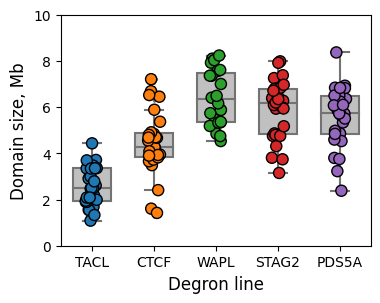

In [15]:
plt.figure(figsize = (4, 3))

sns.boxplot(data = [(tacl_domains['end']-tacl_domains['start']).values/1000000,
                      (tacl_domains['tacl_domain_ctcf_end']-tacl_domains['tacl_domain_ctcf_start']).values/1000000,
                      (tacl_domains['tacl_domain_wapl_end']-tacl_domains['tacl_domain_wapl_start']).values/1000000,
                      (tacl_domains['tacl_domain_stag2_end']-tacl_domains['tacl_domain_stag2_start']).values/1000000,
                      (tacl_domains['tacl_domain_pds5a_end']-tacl_domains['tacl_domain_pds5a_start']).values/1000000],
            color = 'silver', width = 0.6)
sns.stripplot(data = [(tacl_domains['end']-tacl_domains['start']).values/1000000,
                      (tacl_domains['tacl_domain_ctcf_end']-tacl_domains['tacl_domain_ctcf_start']).values/1000000,
                      (tacl_domains['tacl_domain_wapl_end']-tacl_domains['tacl_domain_wapl_start']).values/1000000,
                      (tacl_domains['tacl_domain_stag2_end']-tacl_domains['tacl_domain_stag2_start']).values/1000000,
                      (tacl_domains['tacl_domain_pds5a_end']-tacl_domains['tacl_domain_pds5a_start']).values/1000000],
              edgecolor = 'k', linewidth = 1, size = 8)
plt.xticks([0, 1, 2, 3, 4], ['TACL', 'CTCF', 'WAPL', 'STAG2', 'PDS5A'])
plt.xlabel('Degron line', fontsize = 12)
plt.ylabel('Domain size, Mb', fontsize = 12)
plt.ylim((0, 10))
plt.show()

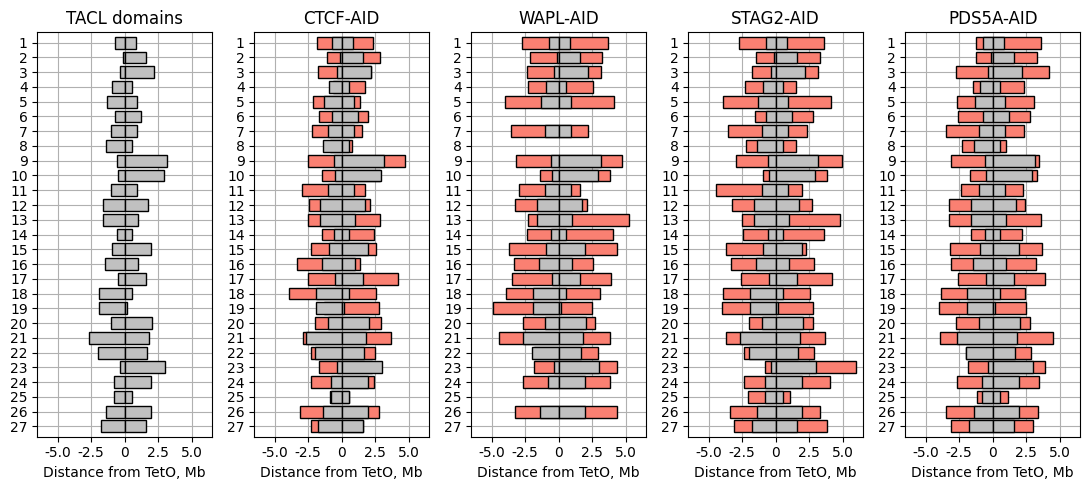

In [16]:
tacl_domains_plotting = tacl_domains.merge(teto_coordinates, on = ['chrom', 'teto_id'], suffixes = ['', '_teto'])

plt.figure(figsize = (11, 5))

plt.subplot(151)
plt.title('TACL domains', fontsize = 12)
plt.barh(-tacl_domains_plotting['teto_id'], tacl_domains_plotting['start']-tacl_domains_plotting['start_teto'],
         color = 'silver', edgecolor = 'k', lw = 1, zorder = 10)
plt.barh(-tacl_domains_plotting['teto_id'], tacl_domains_plotting['end']-tacl_domains_plotting['start_teto'],
         color = 'silver', edgecolor = 'k', lw = 1, zorder = 10)
plt.xticks(np.array([-5, -2.5, 0, 2.5, 5])*1000000, ['-5.0', '-2.5', '0', '2.5', '5.0'])
plt.xlabel('Distance from TetO, Mb')
plt.yticks(-np.arange(28), np.arange(28))
plt.xlim((-6500000, 6500000))
plt.ylim((-27.7, -0.3))
plt.grid(zorder = 0)

for (i, cell_line) in enumerate(['CTCF', 'WAPL', 'STAG2', 'PDS5A']):
    plt.subplot(1, 5, i+2)
    plt.title(cell_line.upper() + '-AID', fontsize = 12)
    
    plt.barh(-tacl_domains_plotting['teto_id'], tacl_domains_plotting[f'tacl_domain_{cell_line.lower()}_start']-tacl_domains_plotting['start_teto'],
             color = 'salmon', edgecolor = 'k', zorder = 10)
    plt.barh(-tacl_domains_plotting['teto_id'], tacl_domains_plotting[f'tacl_domain_{cell_line.lower()}_end']-tacl_domains_plotting['start_teto'],
             color = 'salmon', edgecolor = 'k', zorder = 10)
    
    if cell_line != 'WAPL':
        plt.barh(-tacl_domains_plotting['teto_id'], tacl_domains_plotting['start']-tacl_domains_plotting['start_teto'],
                 color = 'silver', edgecolor = 'k', lw = 1, zorder = 10)
        plt.barh(-tacl_domains_plotting['teto_id'], tacl_domains_plotting['end']-tacl_domains_plotting['start_teto'],
                 color = 'silver', edgecolor = 'k', lw = 1, zorder = 10)
    else:
        plt.barh(-tacl_domains_plotting.dropna()['teto_id'], tacl_domains_plotting.dropna()['start']-tacl_domains_plotting.dropna()['start_teto'],
                 color = 'silver', edgecolor = 'k', lw = 1, zorder = 10)
        plt.barh(-tacl_domains_plotting.dropna()['teto_id'], tacl_domains_plotting.dropna()['end']-tacl_domains_plotting.dropna()['start_teto'],
                 color = 'silver', edgecolor = 'k', lw = 1, zorder = 10)
        
    plt.xticks(np.array([-5, -2.5, 0, 2.5, 5])*1000000, ['-5.0', '-2.5', '0', '2.5', '5.0'])
    plt.xlabel('Distance from TetO, Mb')
    plt.yticks(-np.arange(28), np.arange(28))
    plt.xlim((-6500000, 6500000))
    plt.ylim((-27.7, -0.3))
    plt.grid(zorder = 0)

plt.tight_layout()
plt.show()

### Plot TACL domains

In [27]:
def plot_tacl_domains(viewpoint_data, viewpoint_id, cell_line, condition1, condition2, condition3, teto_coordinates, tacl_domains, flanking_region):
    plt.figure(figsize = (18, 3))
    plt.title(cell_line.upper() + ', TetO #' + str(viewpoint_id) + ', ' + ':'.join([str(x) for x in teto_coordinates[teto_coordinates['teto_id'] == viewpoint_id].values[0][:2]]))
    
    # Plot 4C profiles
    plt.fill_between(viewpoint_data[viewpoint_data['teto_id'] == viewpoint_id]['mid'],
                     0,
                     [min(x) for x in viewpoint_data[viewpoint_data['teto_id'] == viewpoint_id][[condition1, condition2]].values],
                     color = '#CCCCCC')
    
    mask_index = viewpoint_data[(viewpoint_data['teto_id'] == viewpoint_id) & (viewpoint_data[condition1]-viewpoint_data[condition2]>0)].index
    mask_bool = [1 if x in mask_index else 0 for x in viewpoint_data[viewpoint_data['teto_id'] == viewpoint_id].index]
    plt.fill_between(viewpoint_data[viewpoint_data['teto_id'] == viewpoint_id]['mid'],
                     viewpoint_data[viewpoint_data['teto_id'] == viewpoint_id][condition1],
                     viewpoint_data[viewpoint_data['teto_id'] == viewpoint_id][condition2],
                     where = mask_bool, color = 'C1', label = condition1)
    
    mask_index = vp_data_merged[(vp_data_merged['teto_id'] == viewpoint_id) & (vp_data_merged[condition1]-vp_data_merged[condition2]<0)].index
    mask_bool = [1 if x in mask_index else 0 for x in viewpoint_data[viewpoint_data['teto_id'] == viewpoint_id].index]
    plt.fill_between(viewpoint_data[viewpoint_data['teto_id'] == viewpoint_id]['mid'],
                     viewpoint_data[viewpoint_data['teto_id'] == viewpoint_id][condition1],
                     viewpoint_data[viewpoint_data['teto_id'] == viewpoint_id][condition2],
                     where = mask_bool, color = 'C2', label = condition2)

    # Plot TACL domains in degron condition
    plt.fill_betweenx(np.arange(1000), 
                      tacl_domains[tacl_domains['teto_id'] == viewpoint_id][f'tacl_domain_{cell_line}_start'].values[0], 
                      tacl_domains[tacl_domains['teto_id'] == viewpoint_id][f'tacl_domain_{cell_line}_end'].values[0],
                      color = 'orange', alpha = 0.25, zorder = 3, label = 'Degron TACL domain')
    plt.axvline(tacl_domains[tacl_domains['teto_id'] == viewpoint_id][f'tacl_domain_{cell_line}_start'].values[0], 
                color = 'orange', alpha = 0.25, zorder = 3)
    plt.axvline(tacl_domains[tacl_domains['teto_id'] == viewpoint_id][f'tacl_domain_{cell_line}_end'].values[0], 
                color = 'orange', alpha = 0.25, zorder = 3)
    
    # Plot TACL domains in TACL-ON condition
    plt.axvline(tacl_domains[tacl_domains['teto_id'] == viewpoint_id]['start'].values[0],
                color = 'blue', alpha = 1, zorder = 3, label = 'Original TACL domain')
    plt.axvline(tacl_domains[tacl_domains['teto_id'] == viewpoint_id]['end'].values[0], 
                color = 'blue', alpha = 1, zorder = 3)
    
    # Plot TetO integration
    plt.axvline(teto_coordinates[teto_coordinates['teto_id'] == viewpoint_id]['start'].values[0], color = 'k')
    
    plt.xlim((tacl_domains[tacl_domains['teto_id'] == viewpoint_id][f'start'].values[0]-flanking_region,
              tacl_domains[tacl_domains['teto_id'] == viewpoint_id][f'end'].values[0]+flanking_region))
    plt.ylim((0, 1000))
    plt.legend()
    plt.show()

#### STAG2

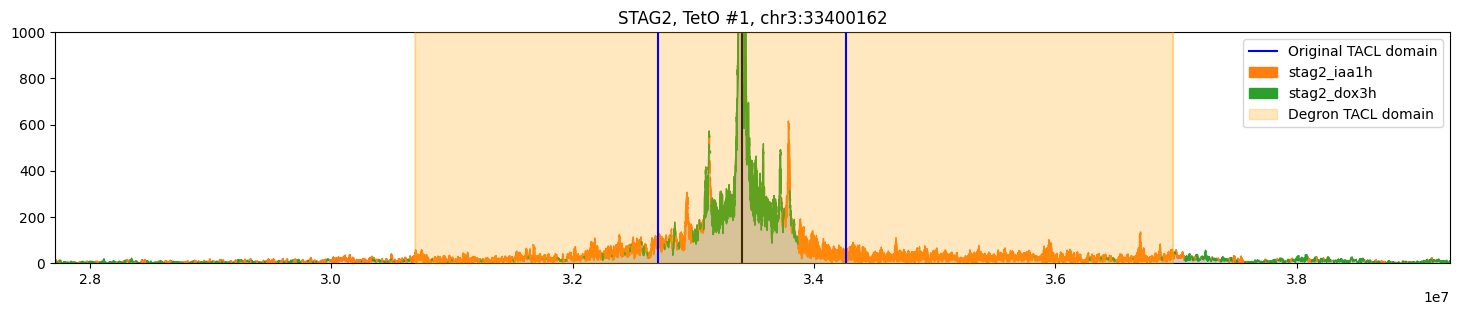

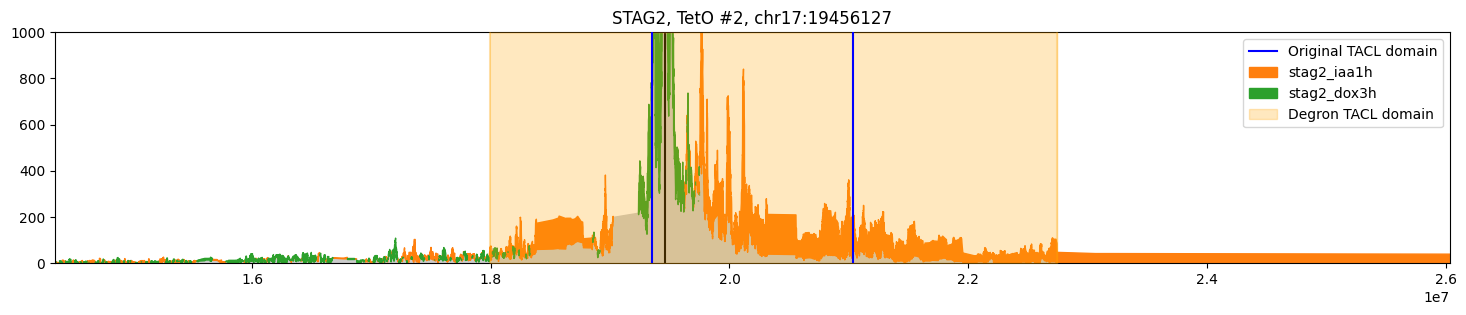

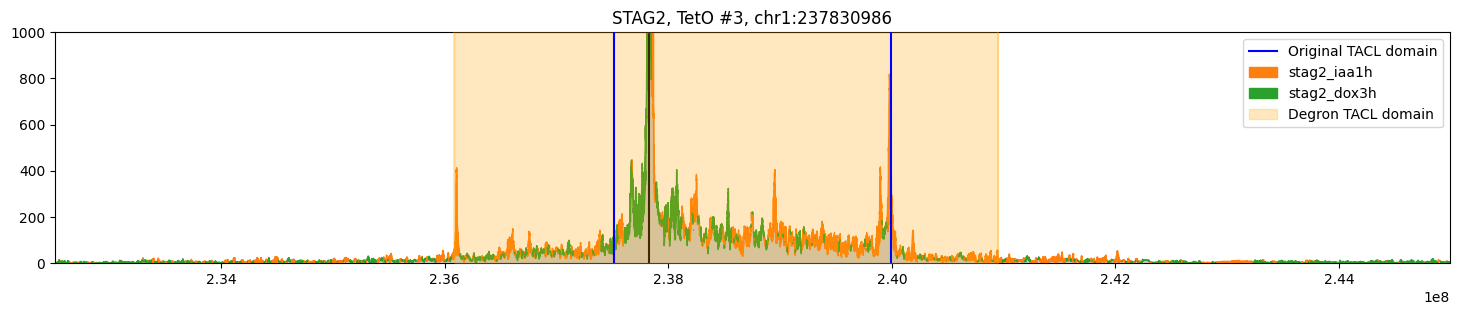

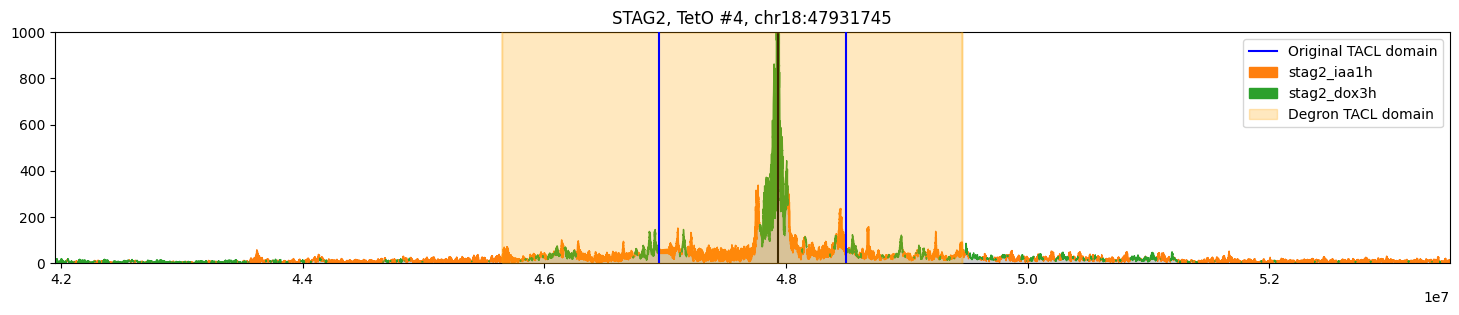

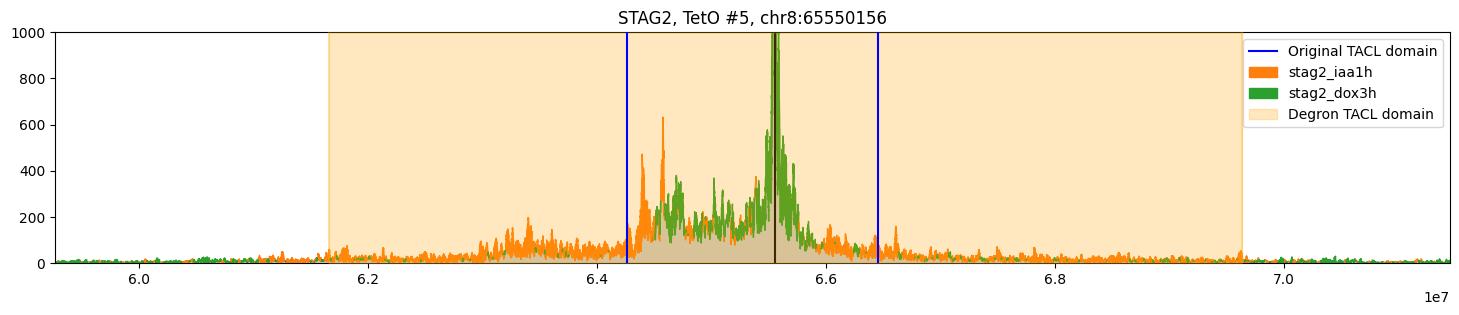

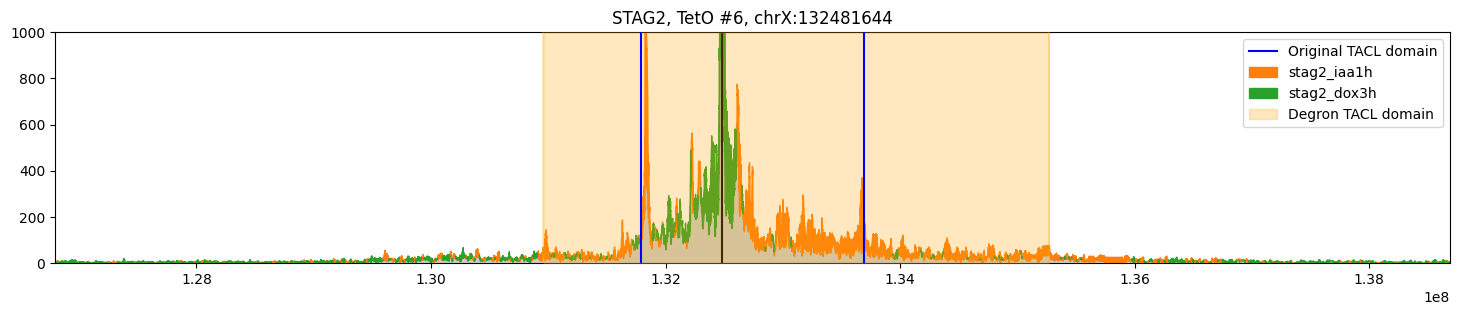

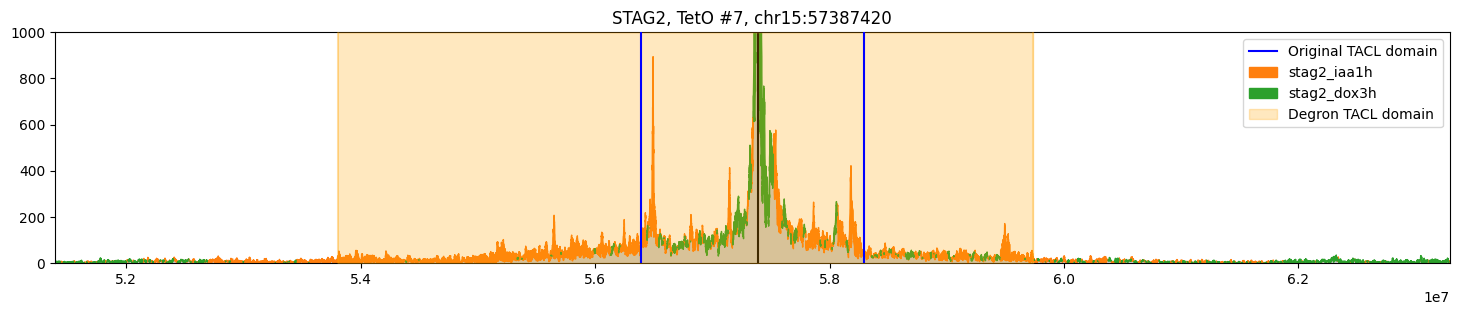

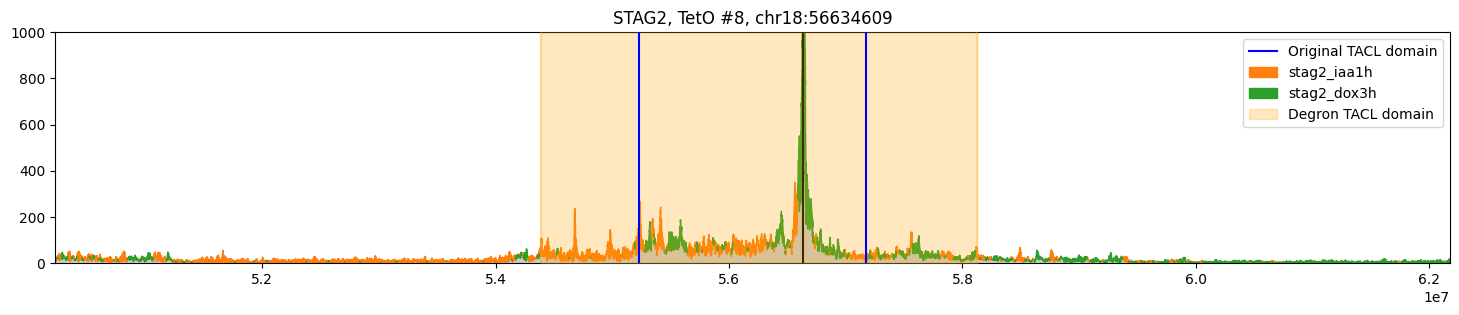

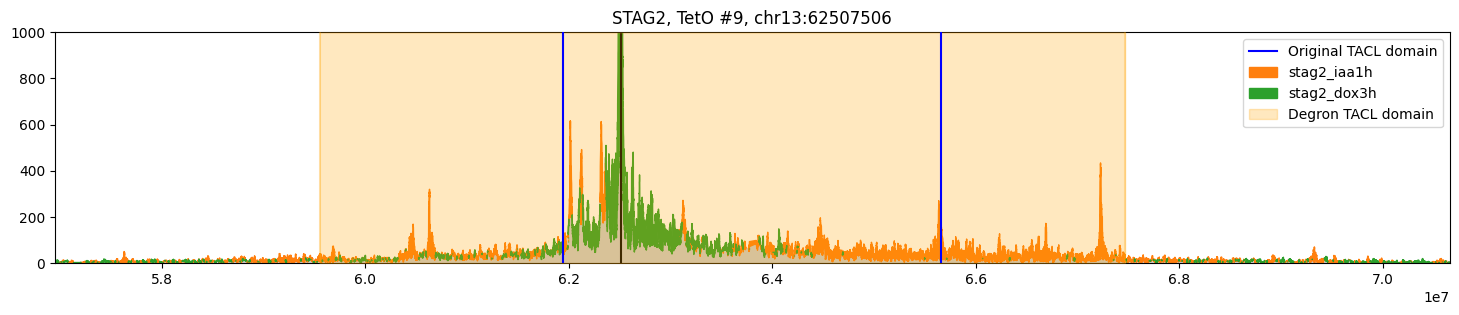

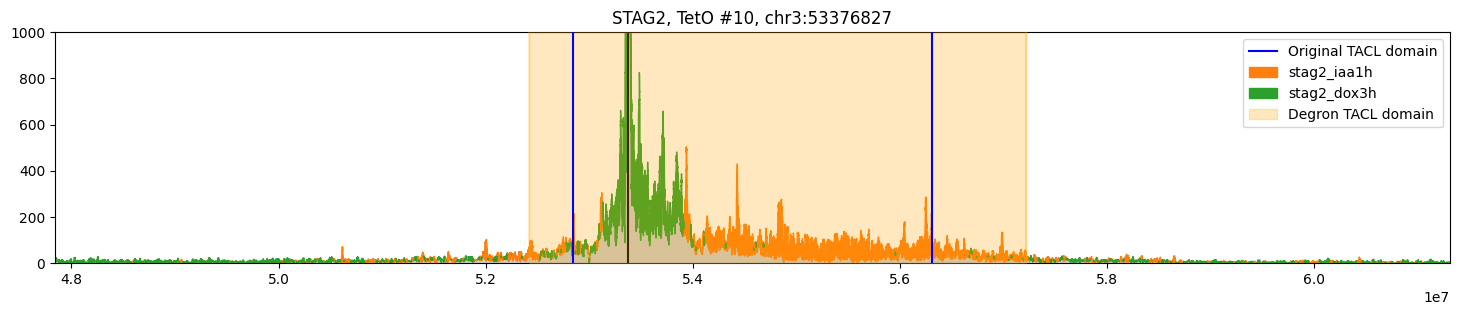

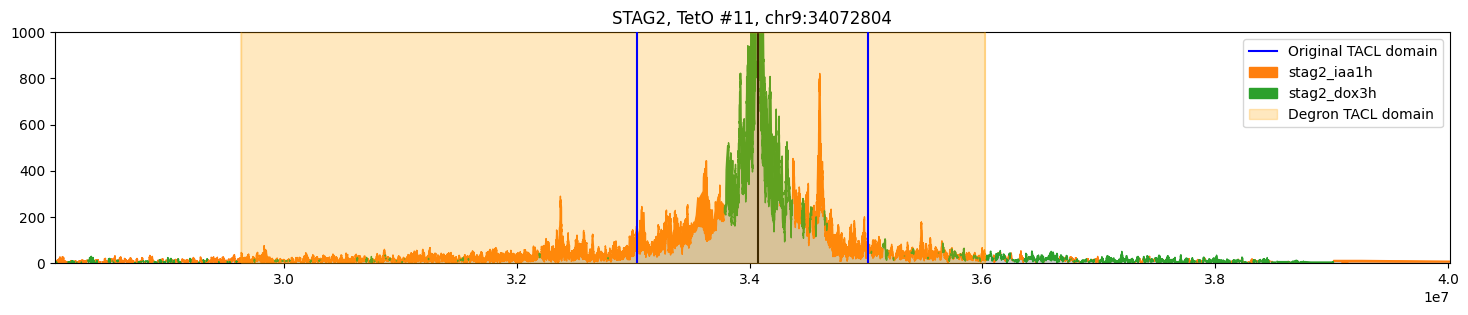

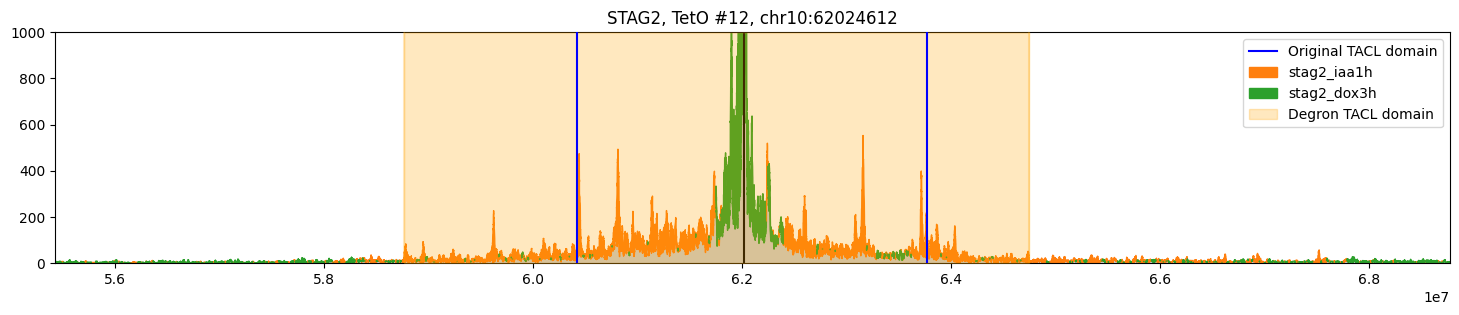

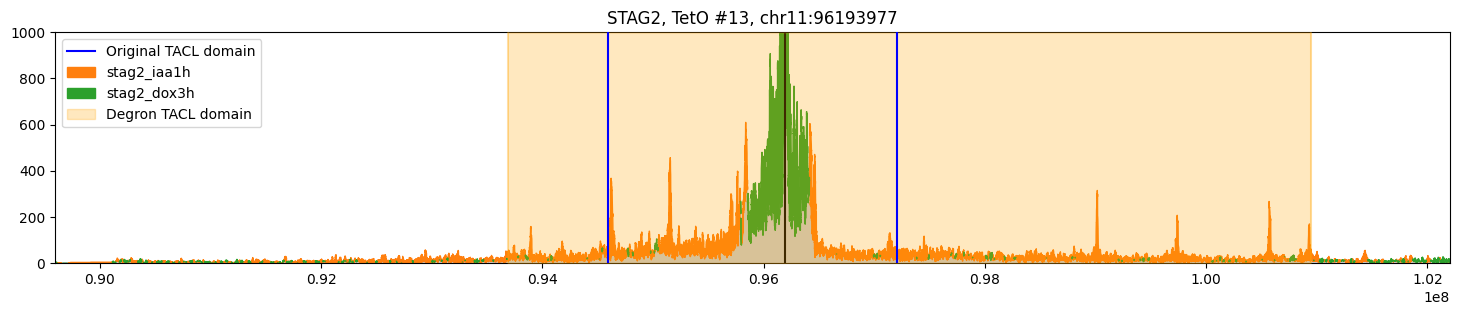

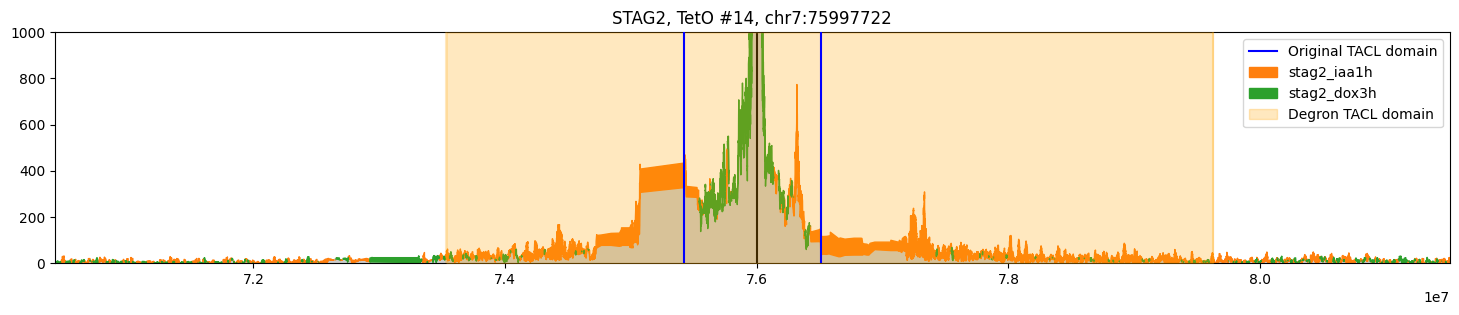

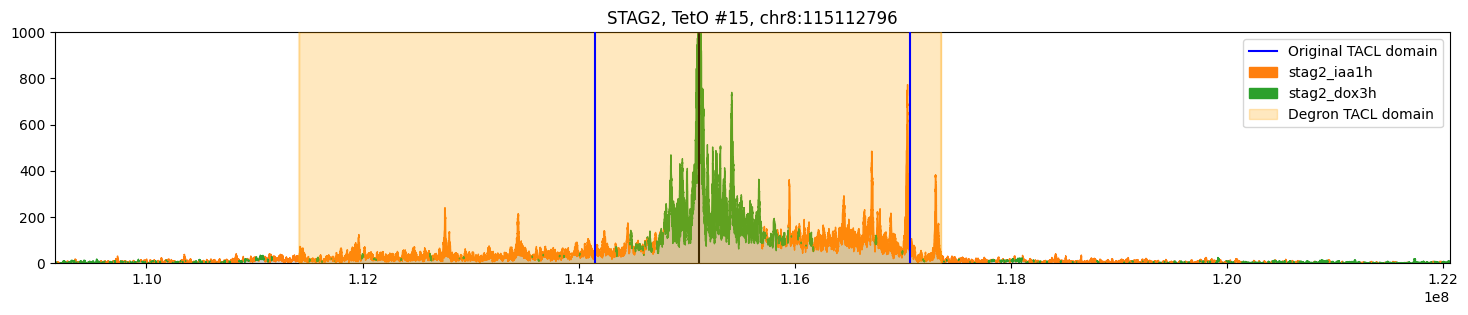

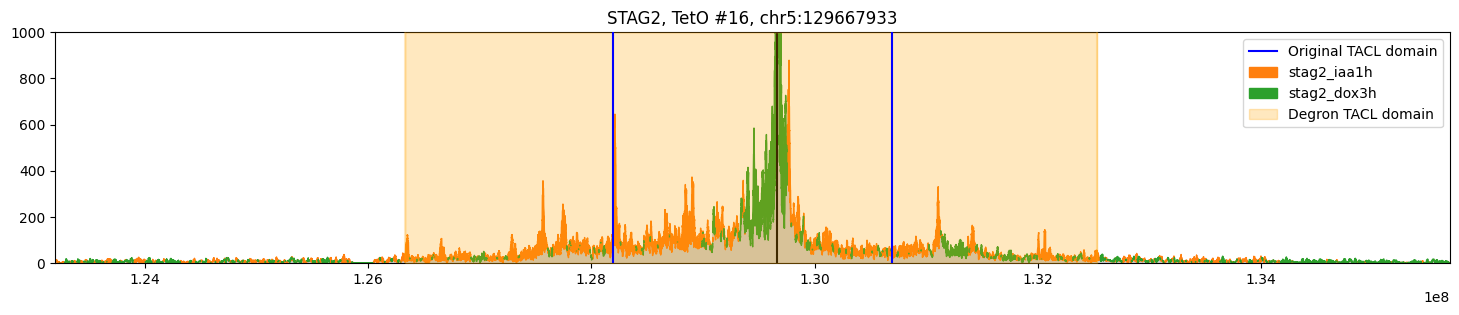

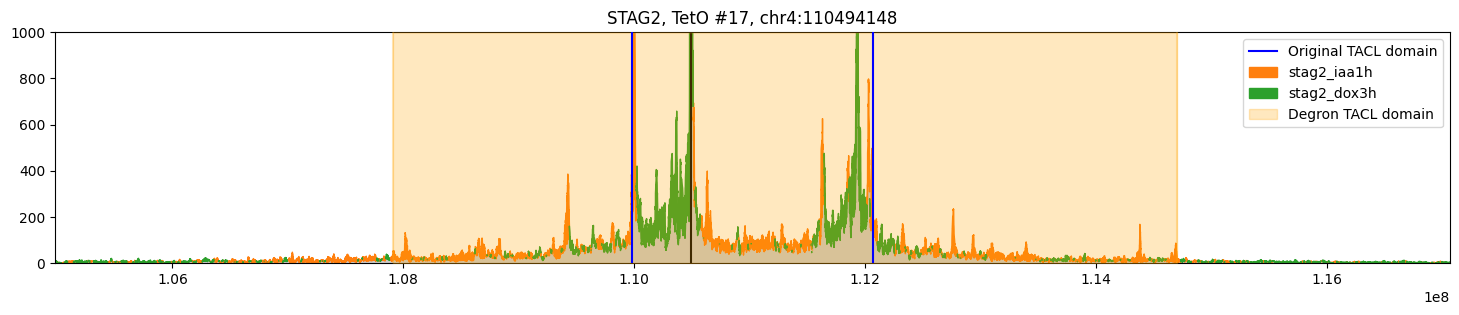

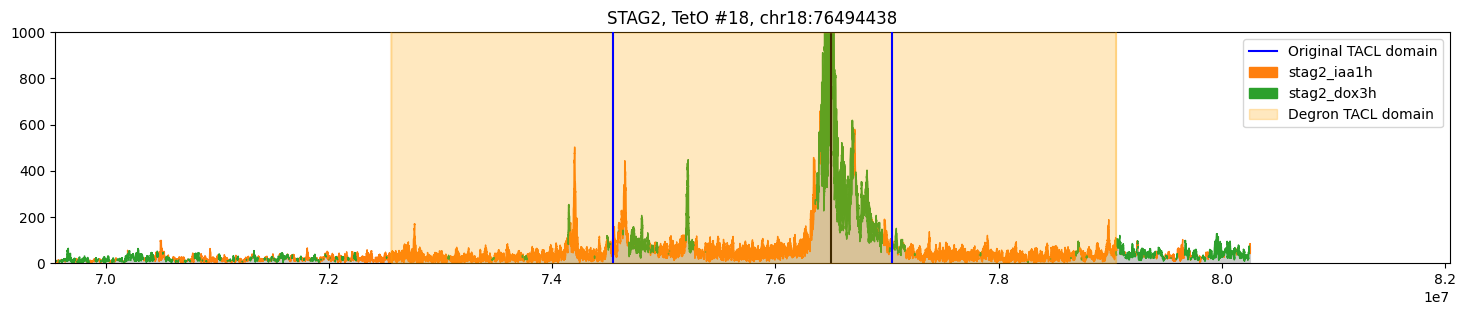

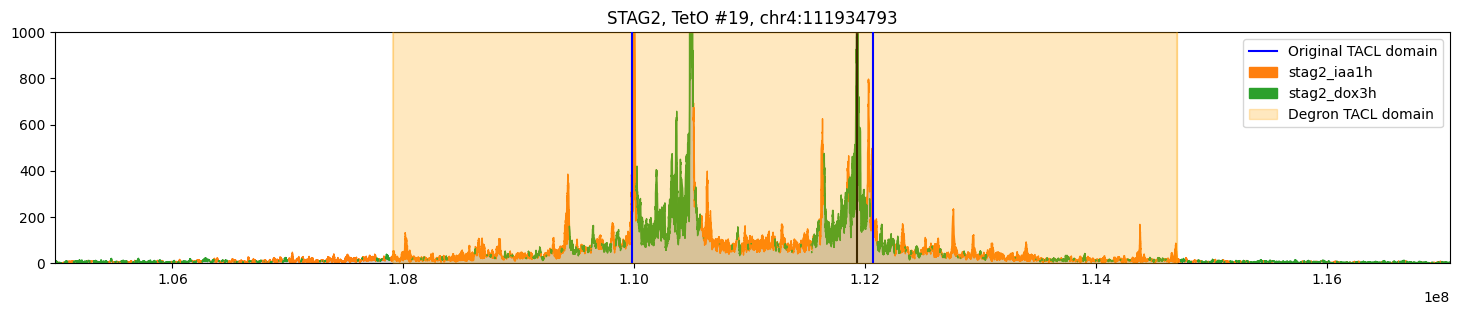

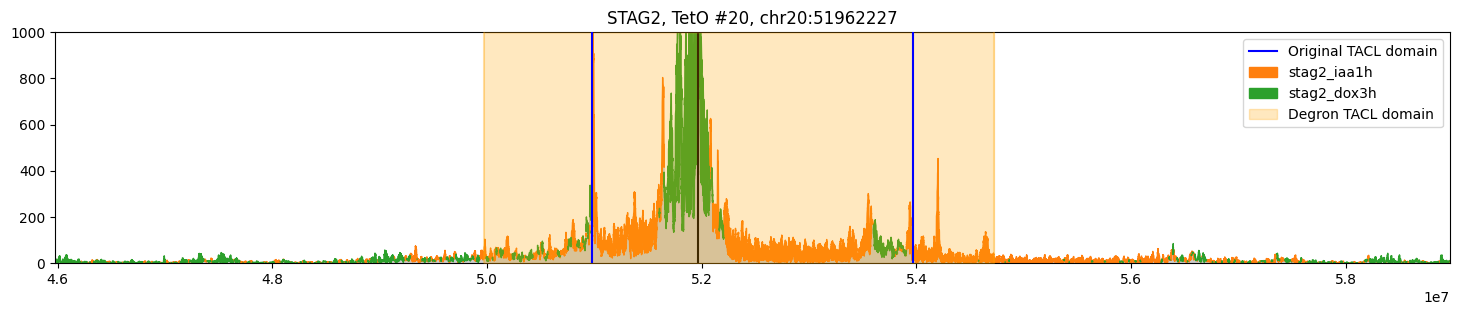

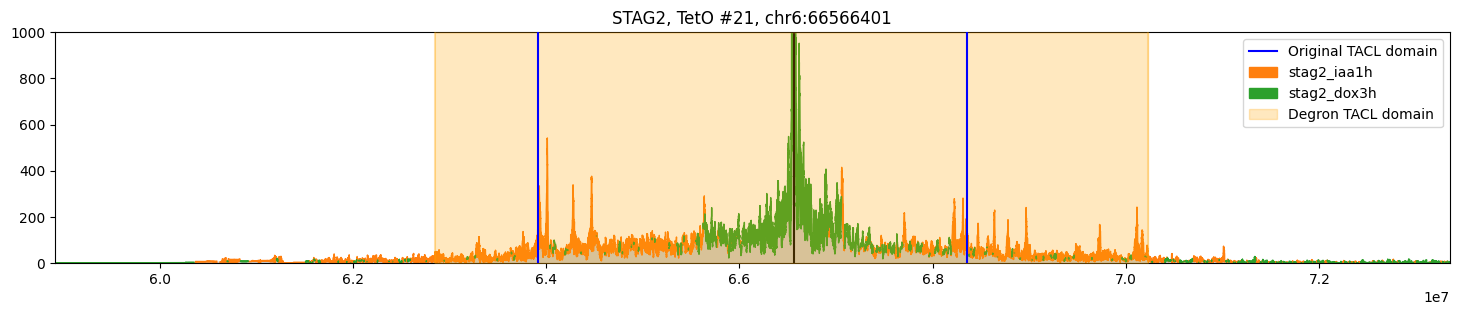

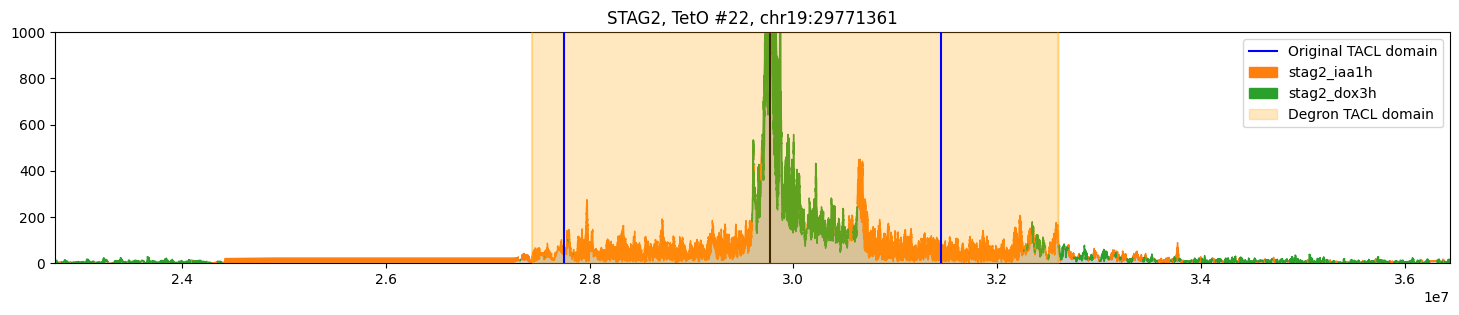

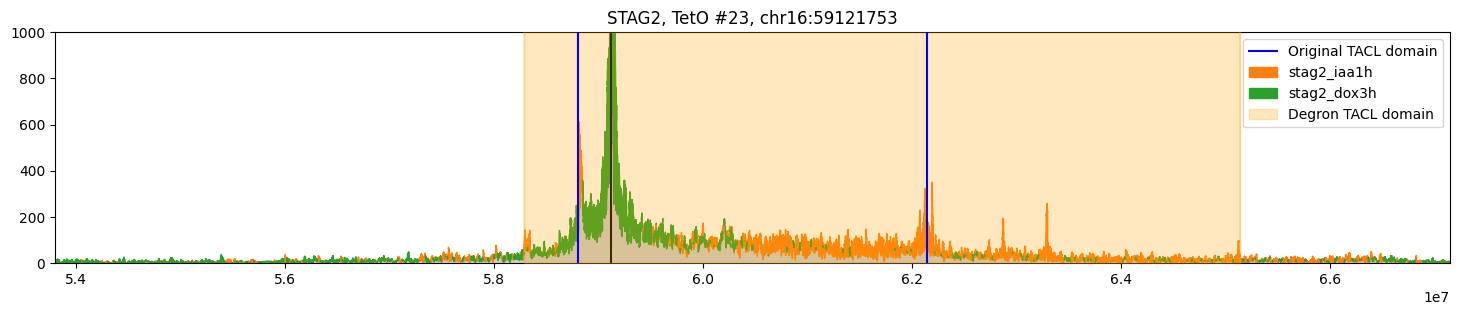

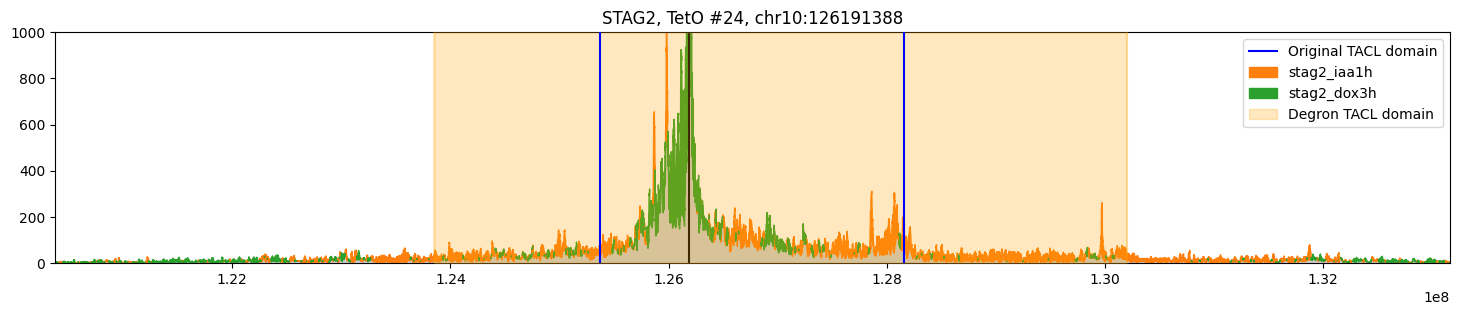

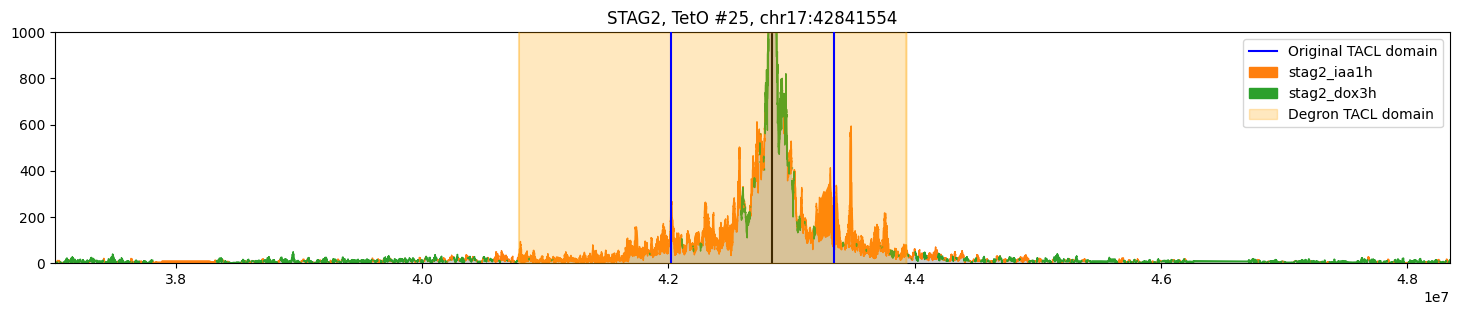

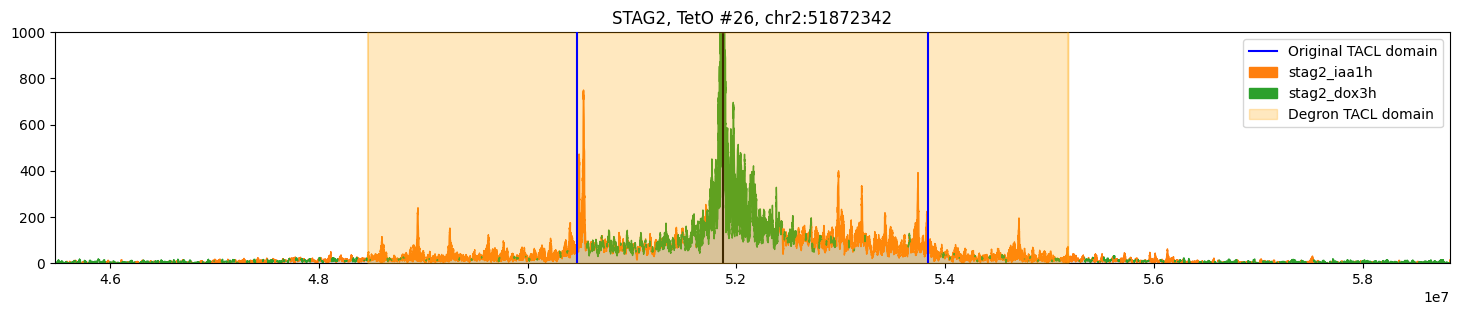

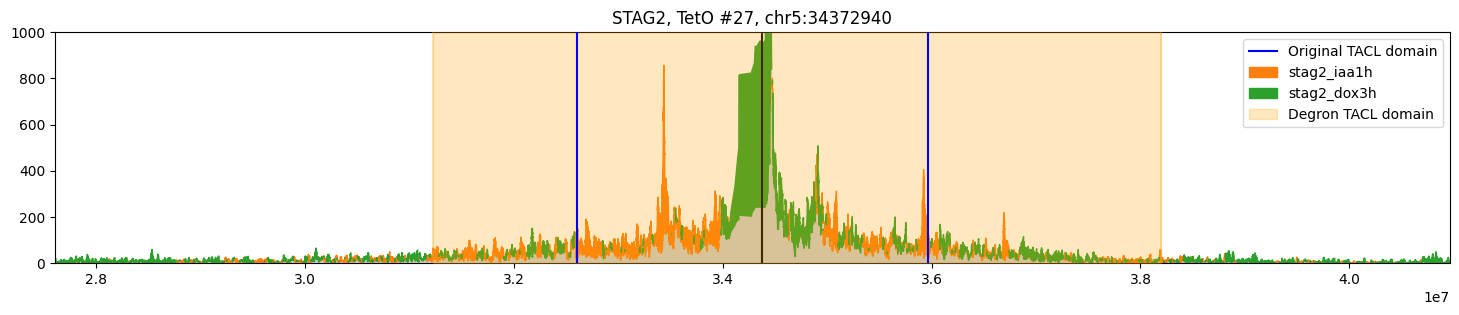

In [31]:
failed_viewpoints = []

for viewpoint_id_hmm in range(1, 28):
    if viewpoint_id_hmm not in failed_viewpoints:
        plot_tacl_domains(vp_data_merged, viewpoint_id_hmm, 'stag2', 'stag2_iaa1h', 'stag2_dox3h', 'stag2_unt', teto_coordinates, tacl_domains, 5000000)

#### WAPL

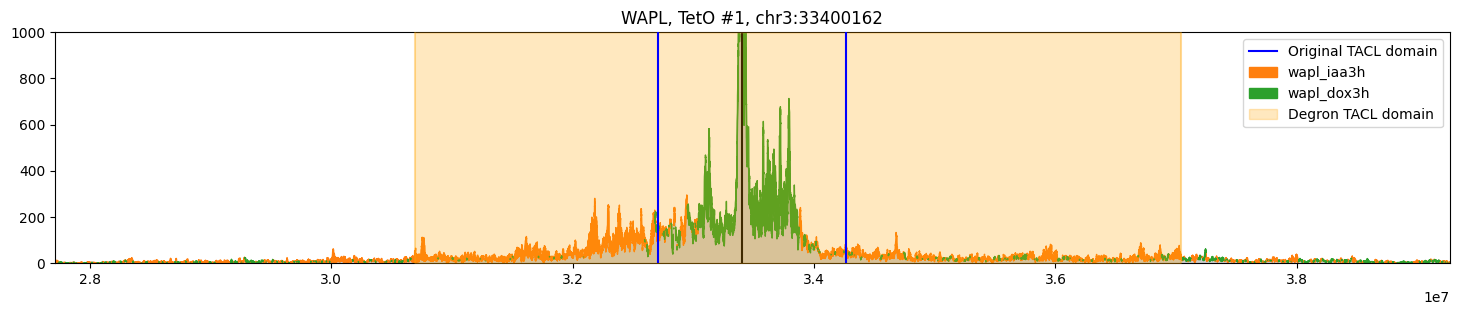

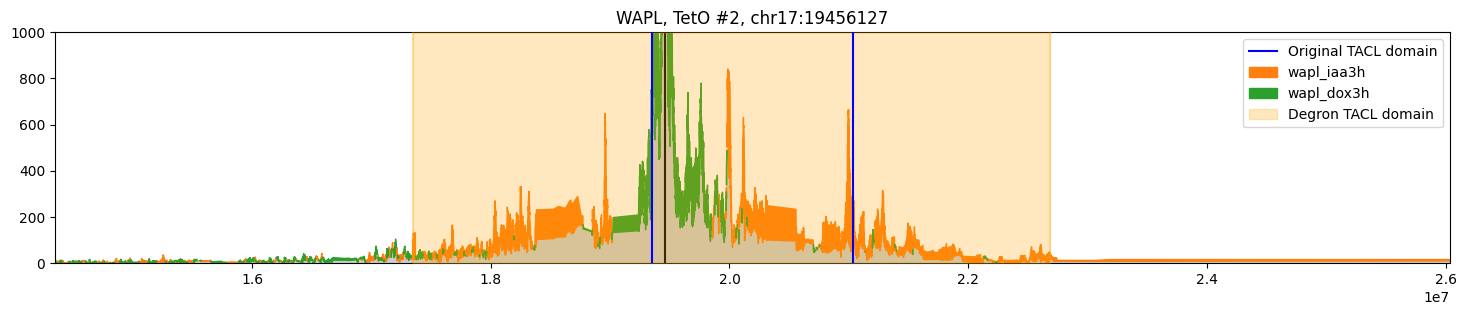

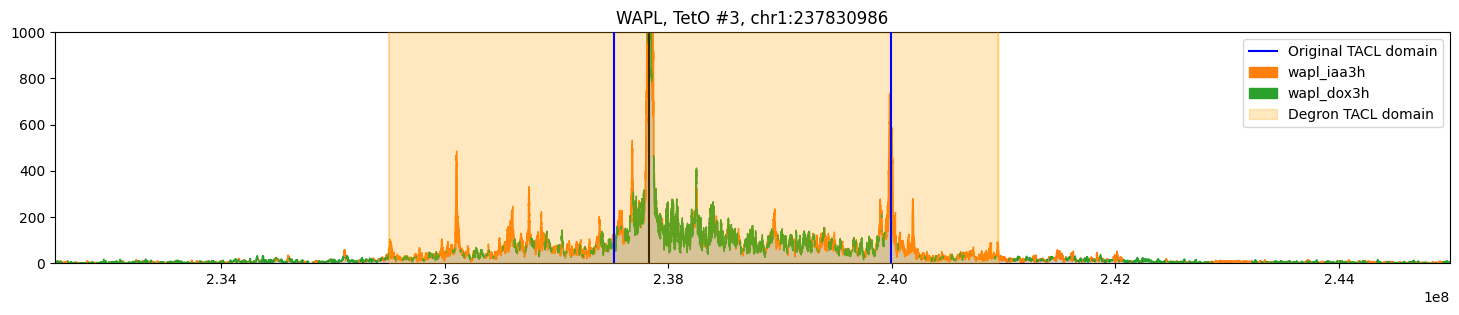

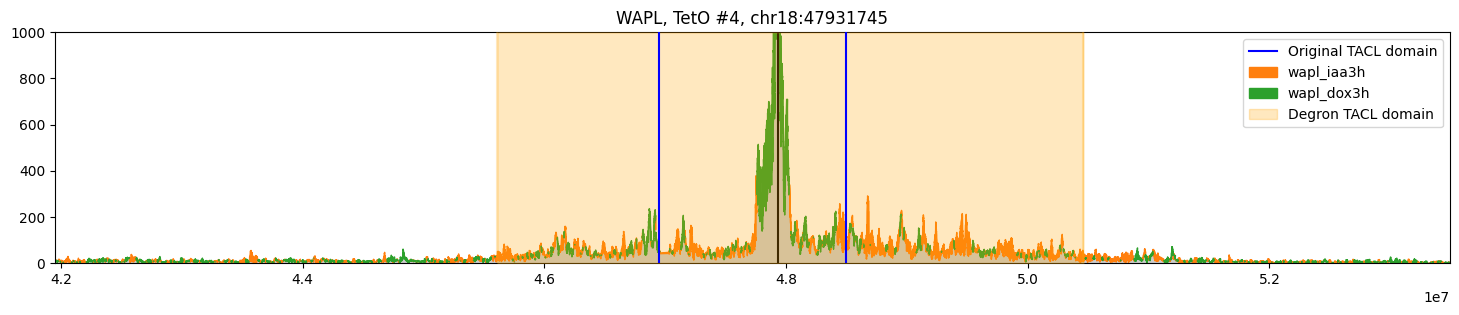

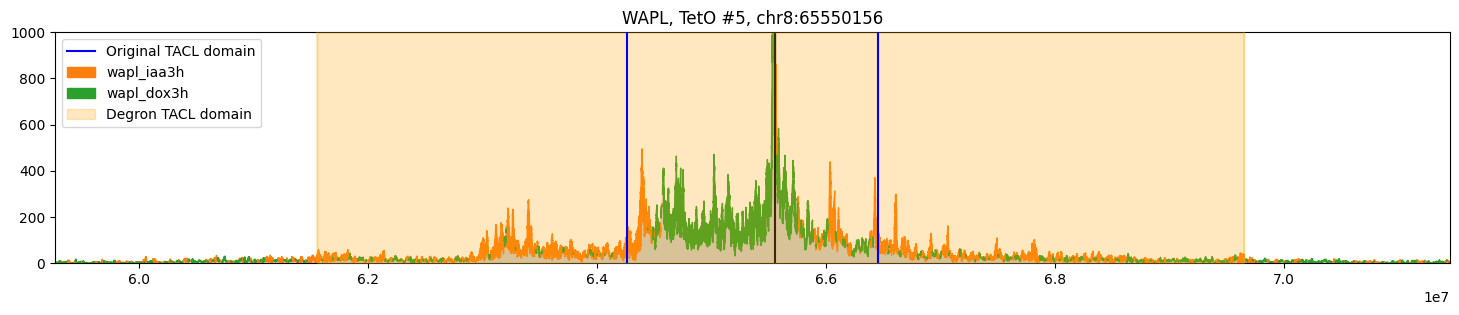

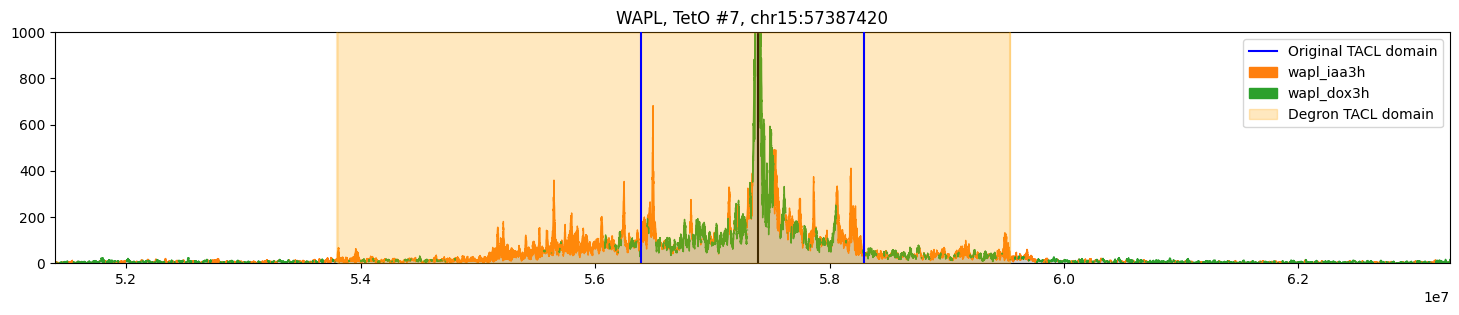

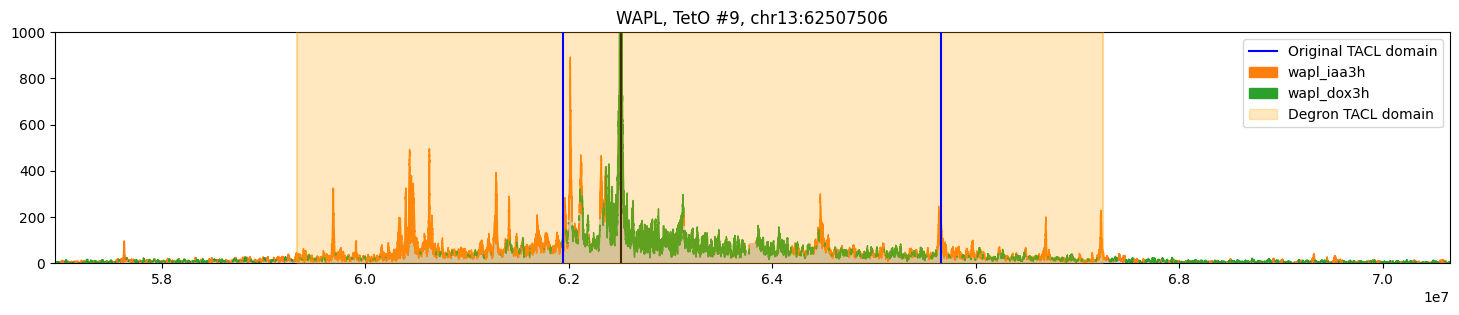

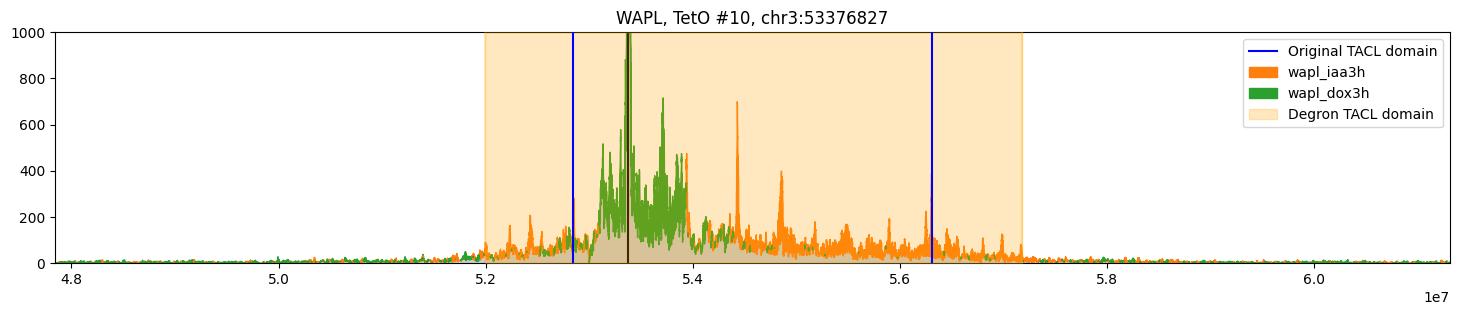

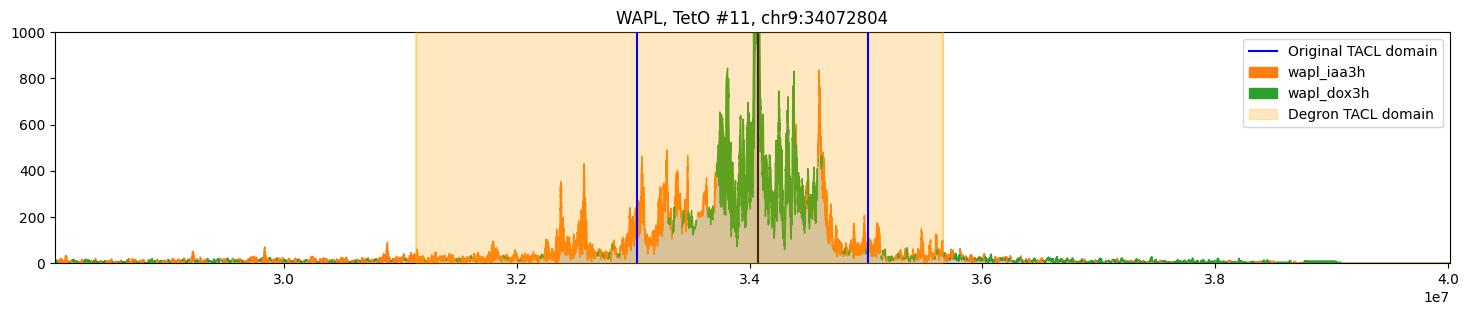

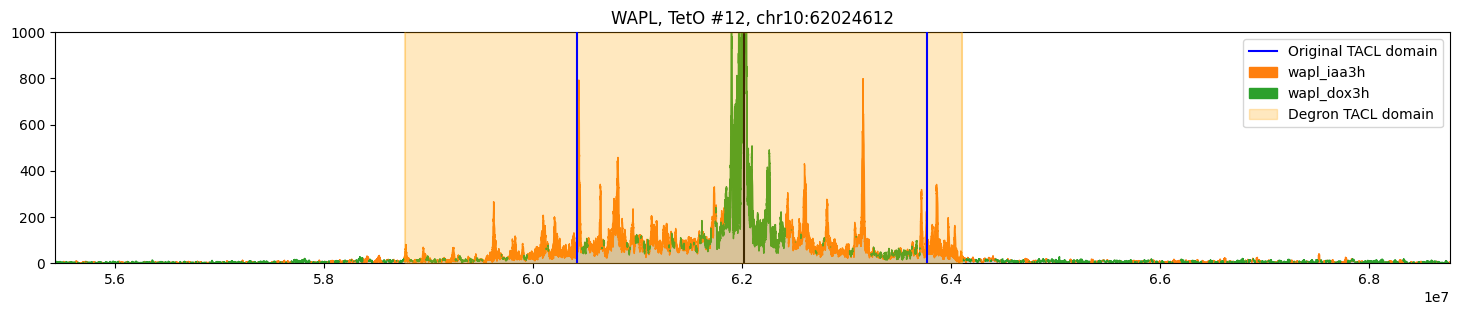

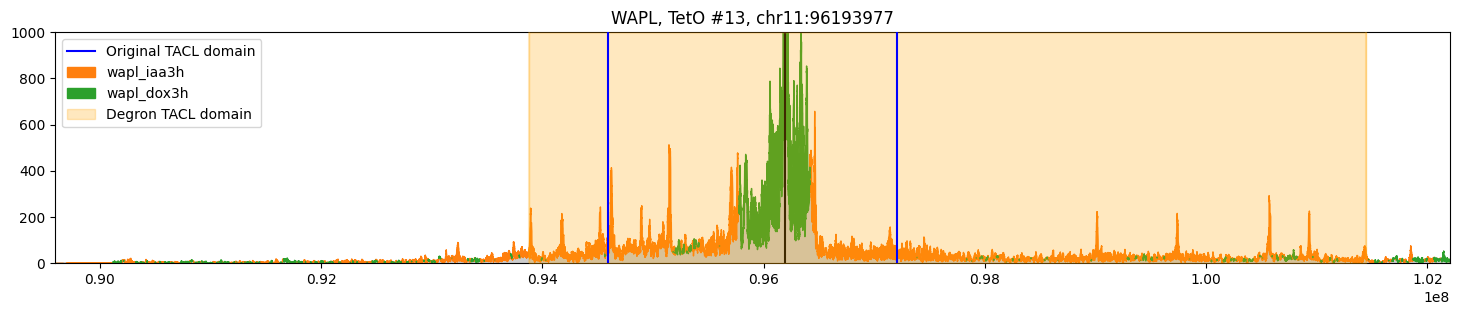

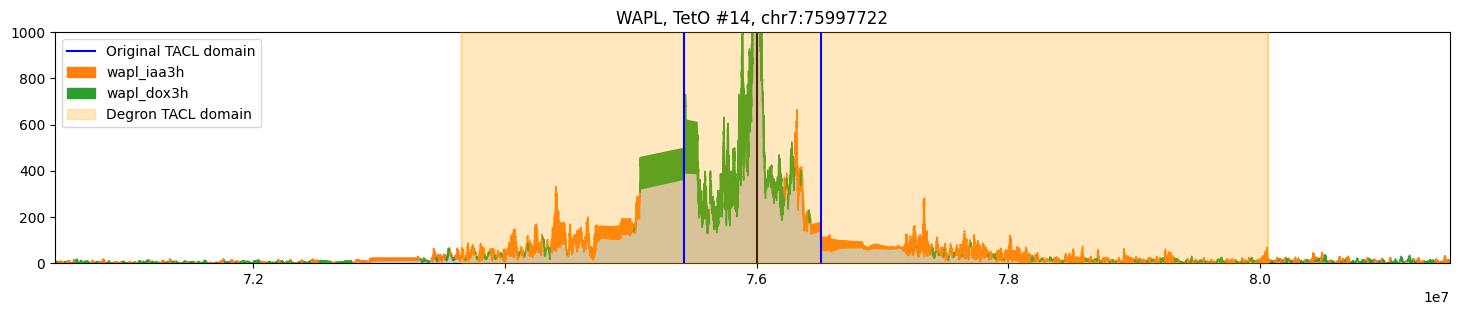

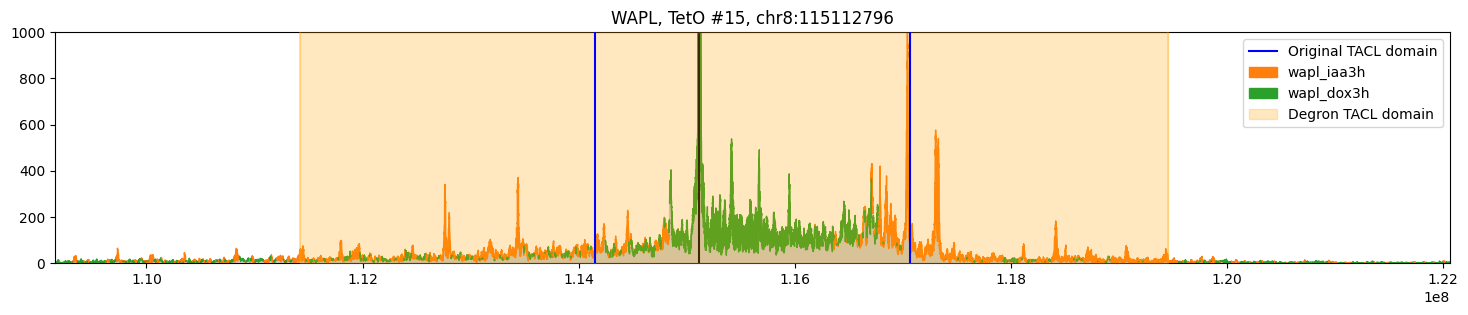

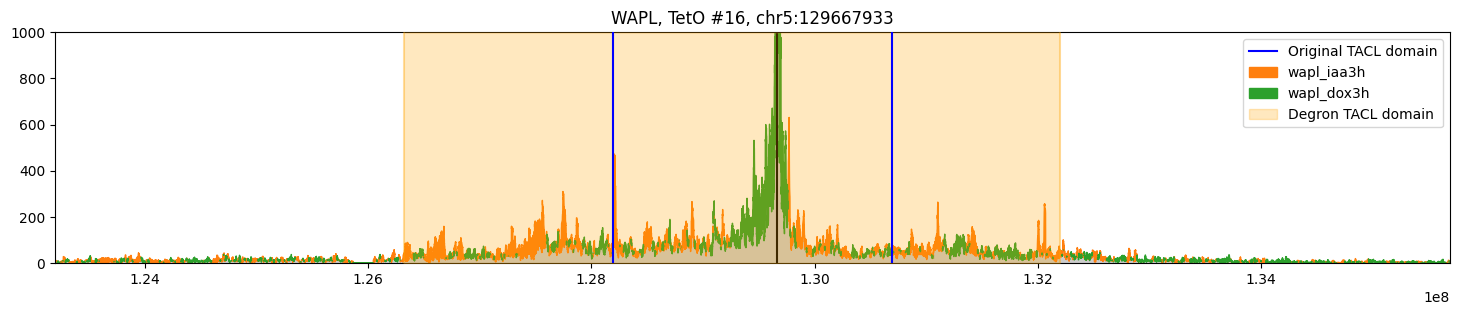

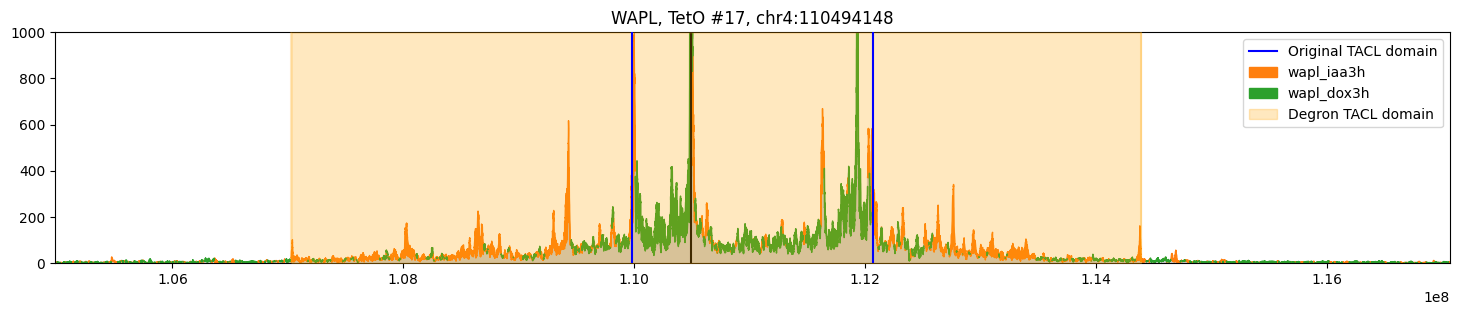

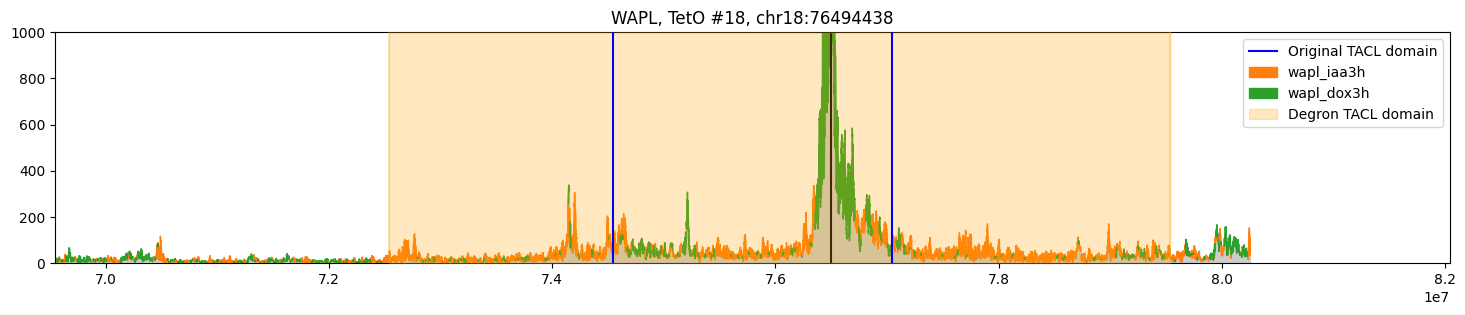

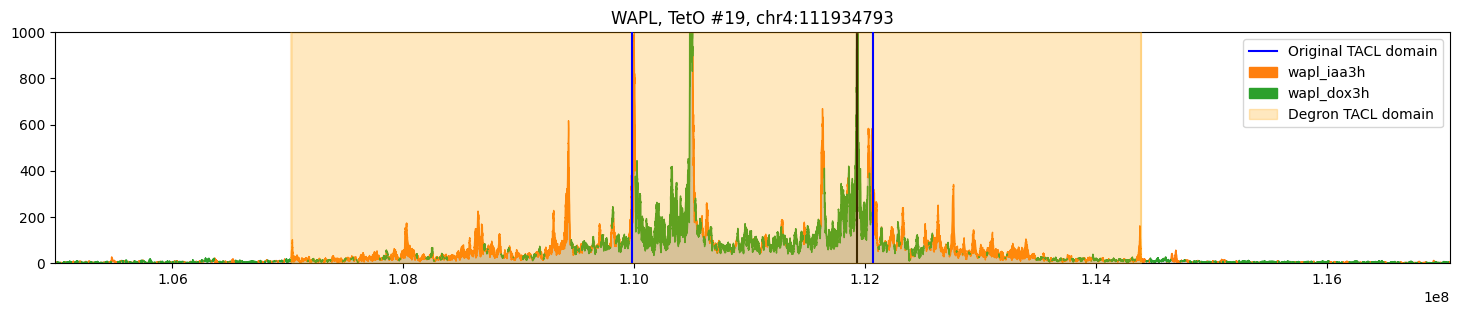

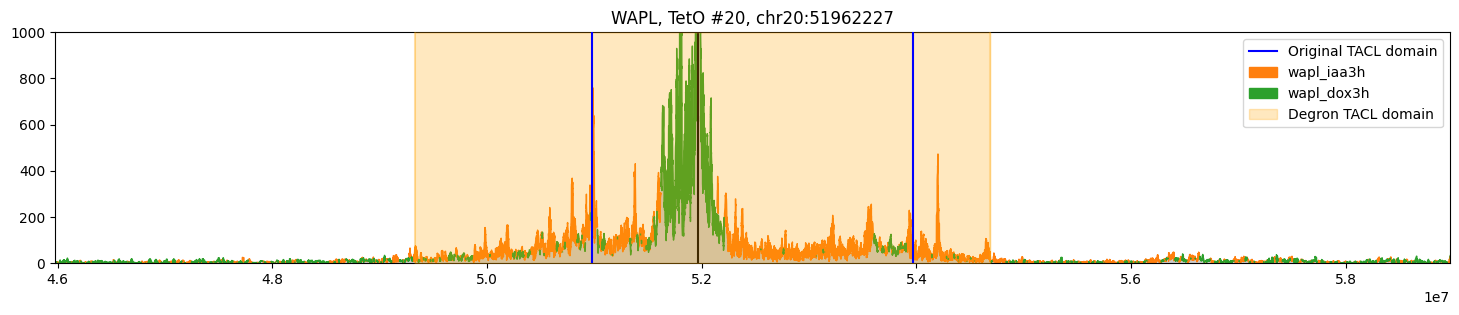

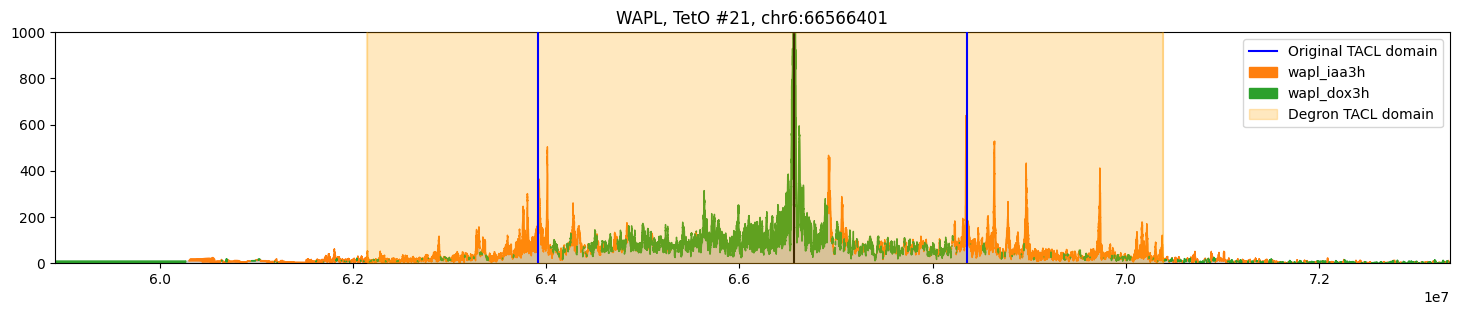

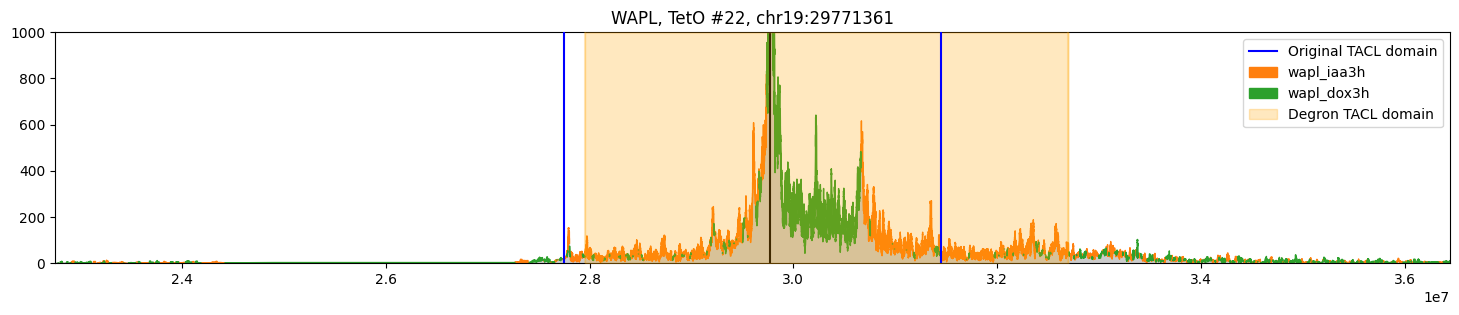

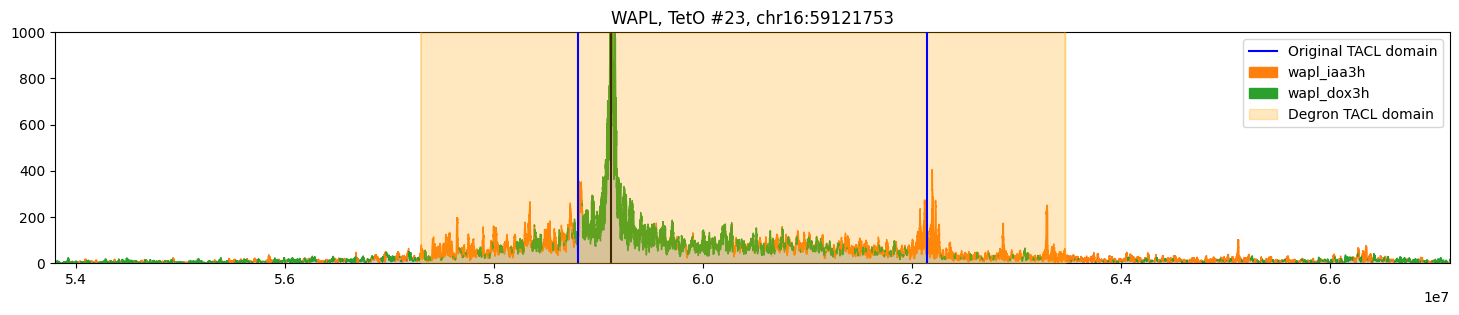

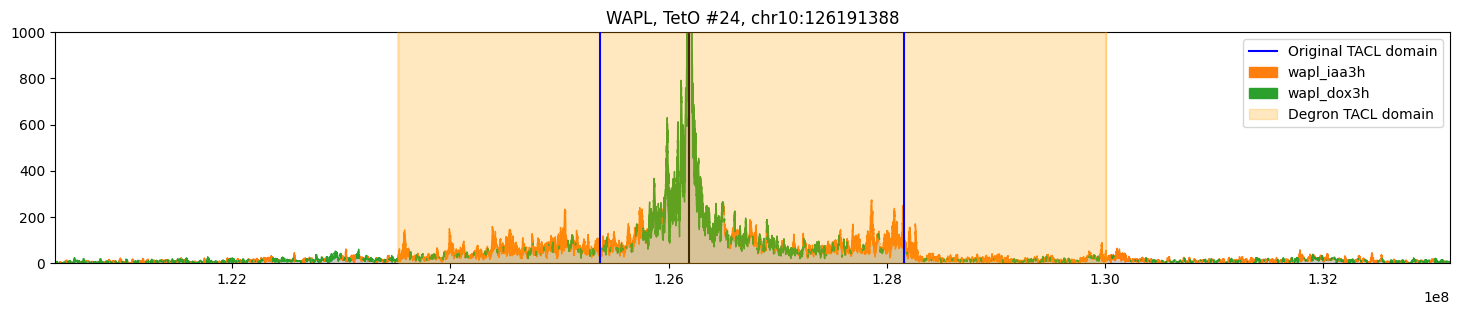

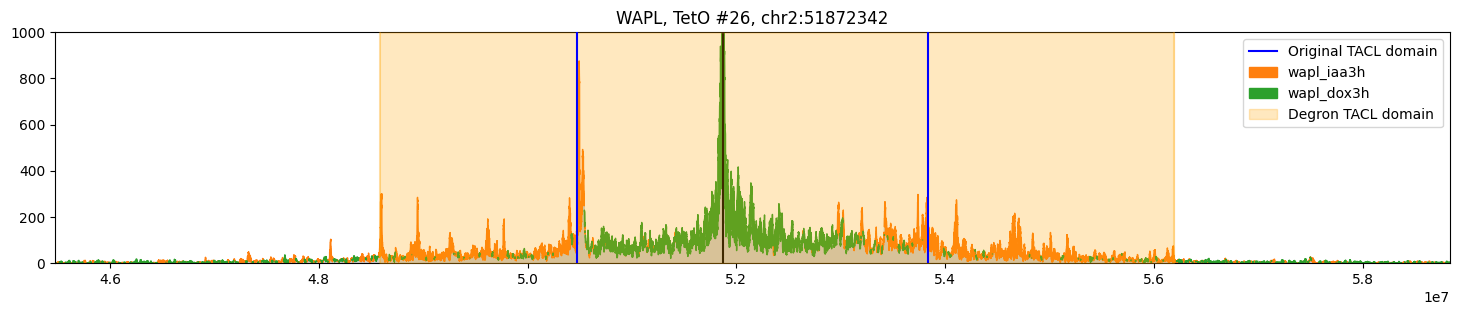

In [32]:
failed_viewpoints = [6, 8, 25, 27]

for viewpoint_id_hmm in range(1, 28):
    if viewpoint_id_hmm not in failed_viewpoints:
        plot_tacl_domains(vp_data_merged, viewpoint_id_hmm, 'wapl', 'wapl_iaa3h', 'wapl_dox3h', 'wapl_unt', teto_coordinates, tacl_domains, 5000000)

#### CTCF

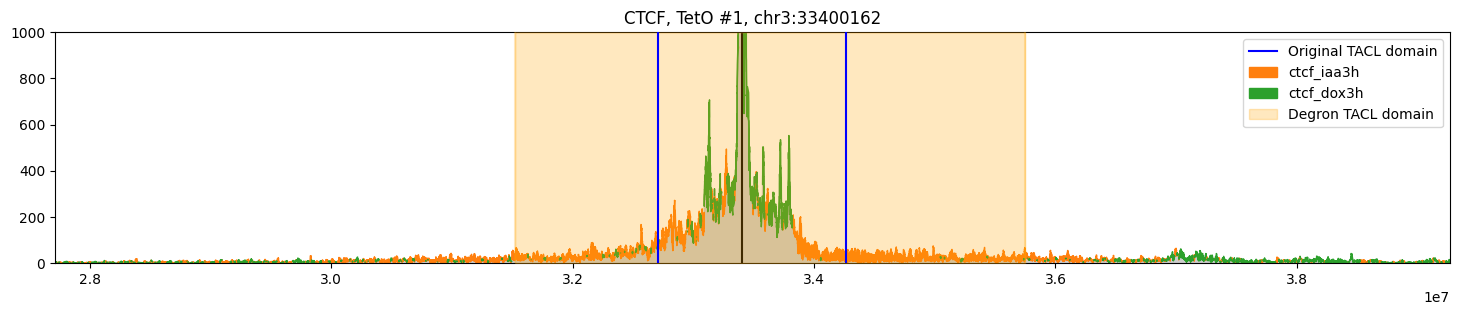

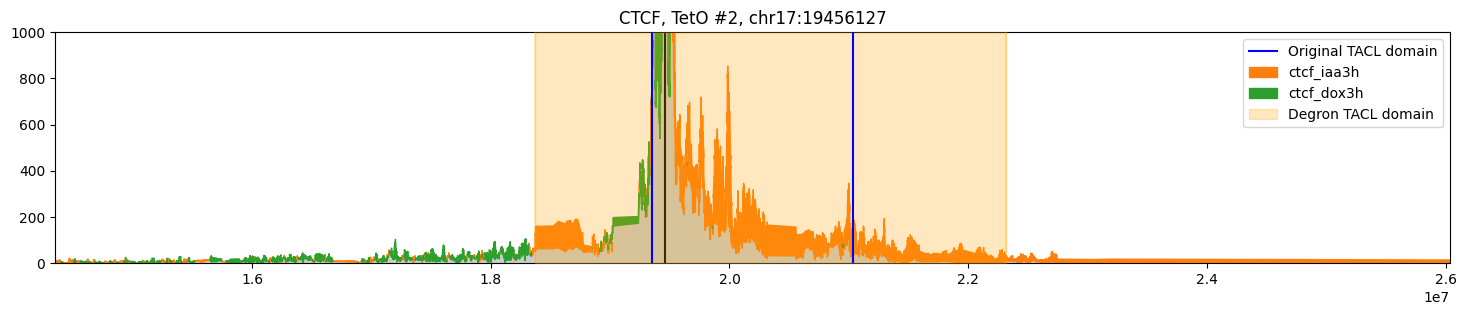

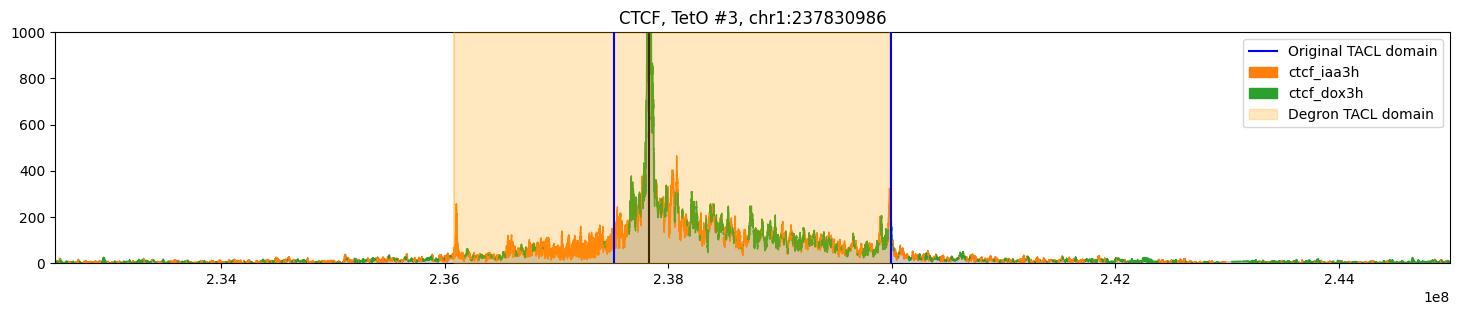

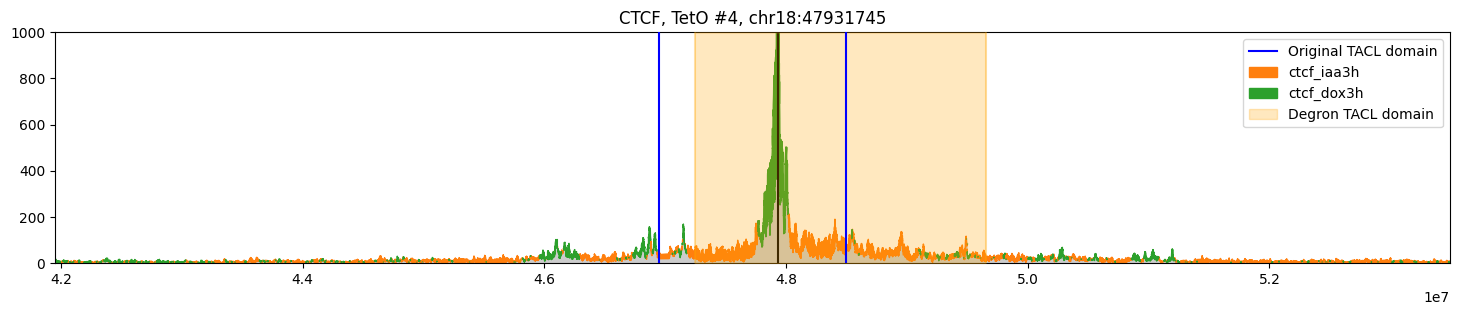

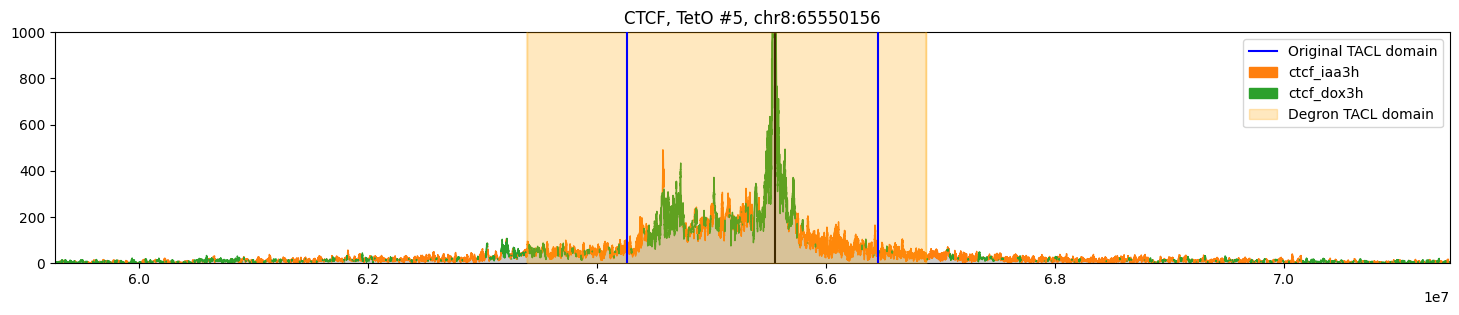

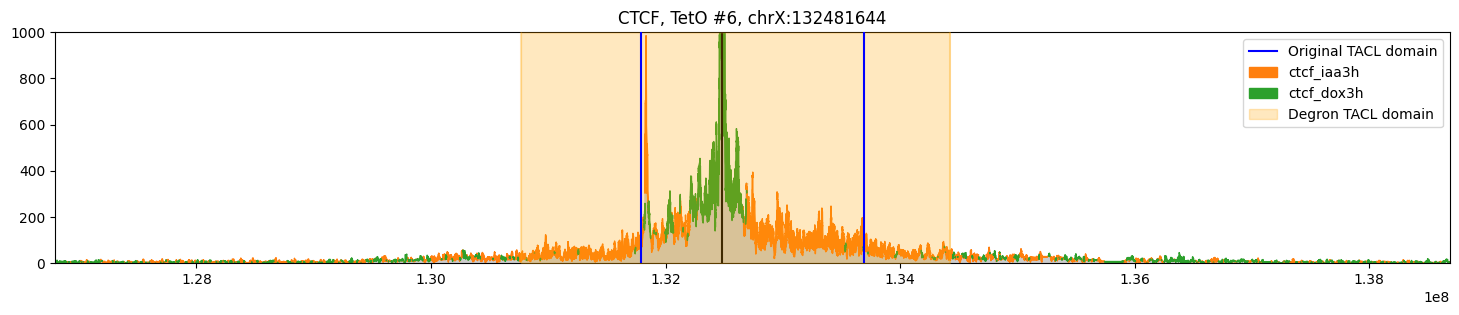

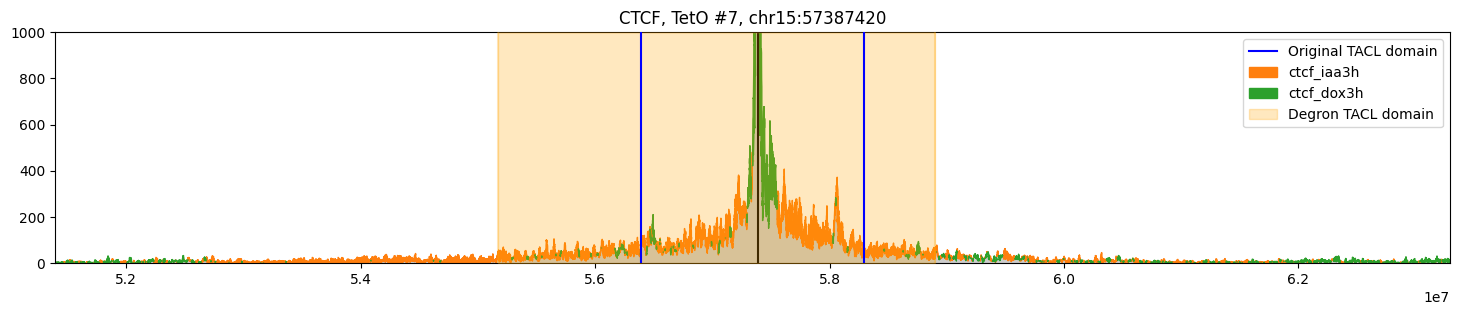

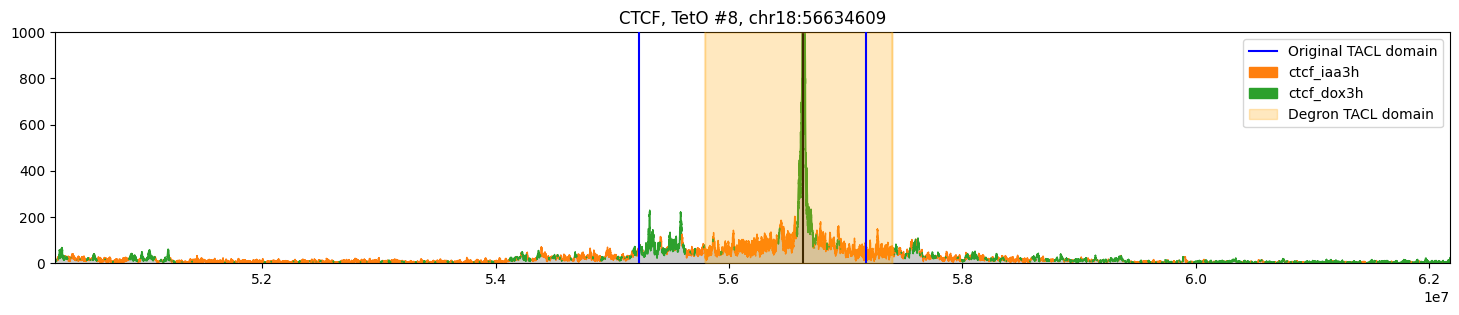

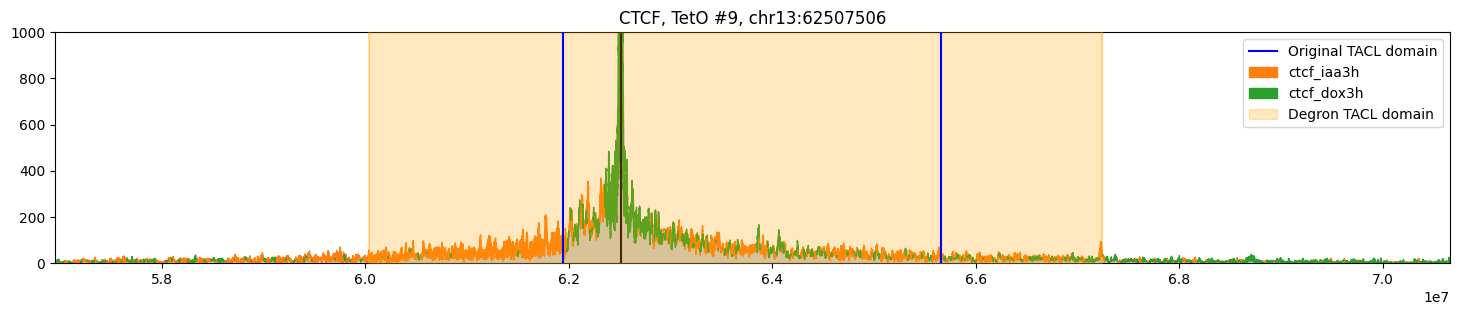

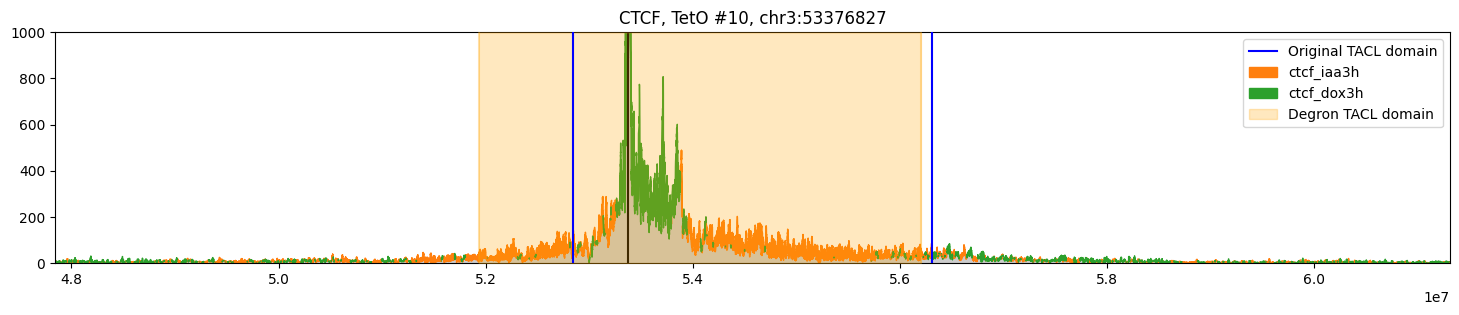

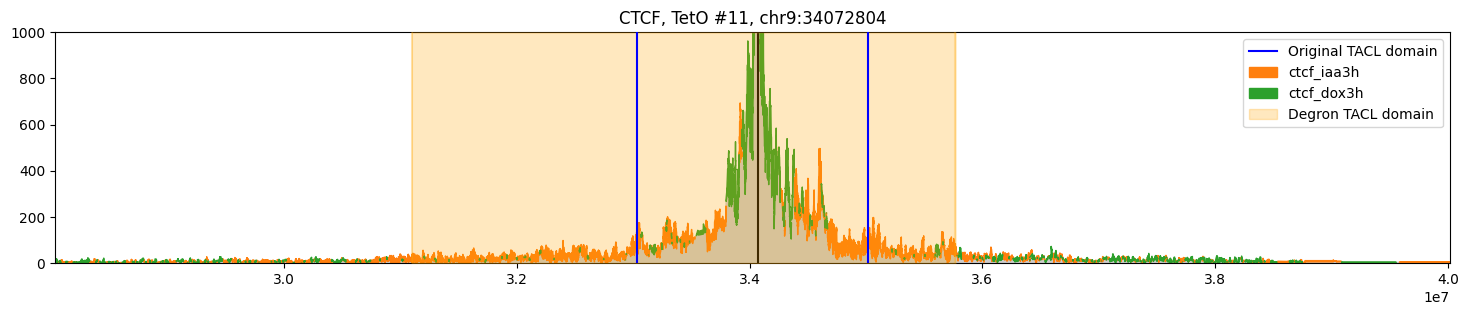

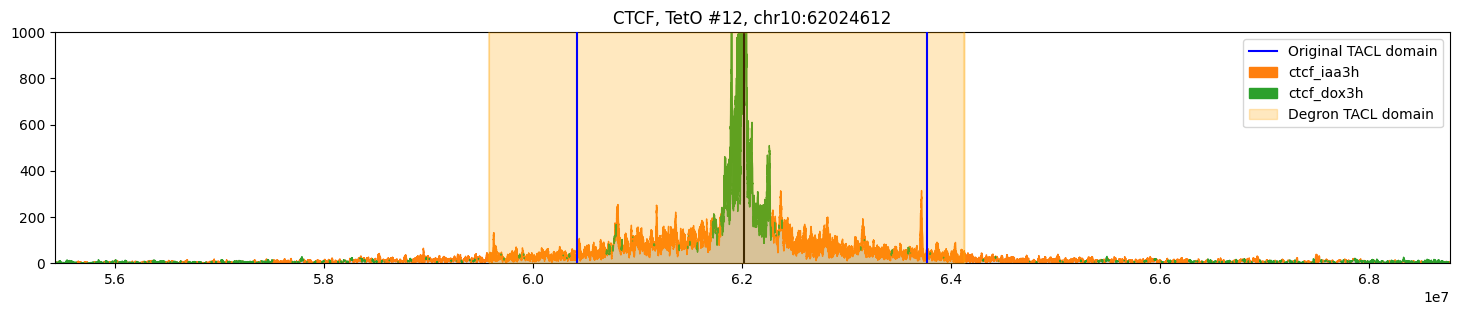

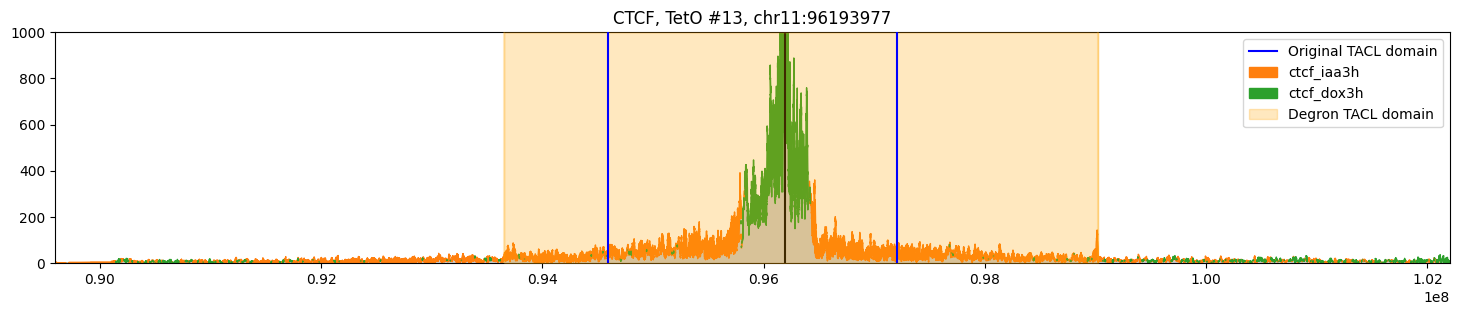

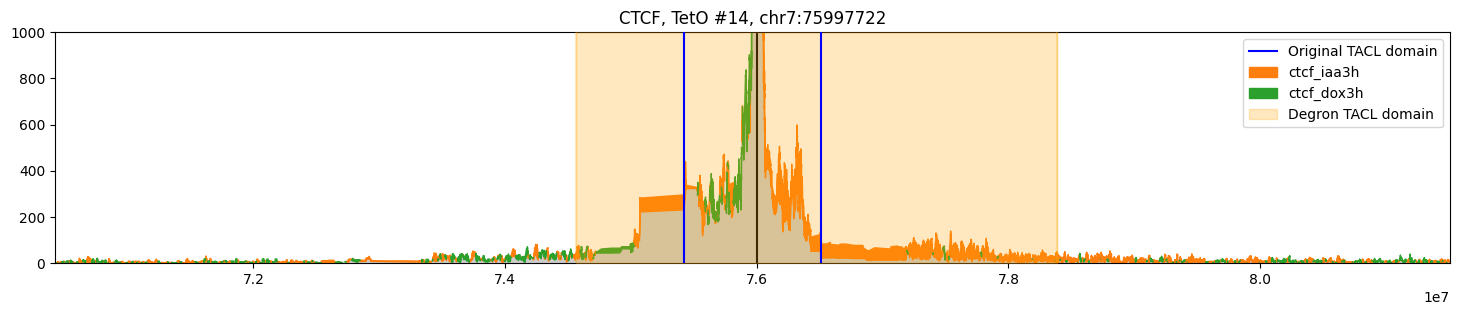

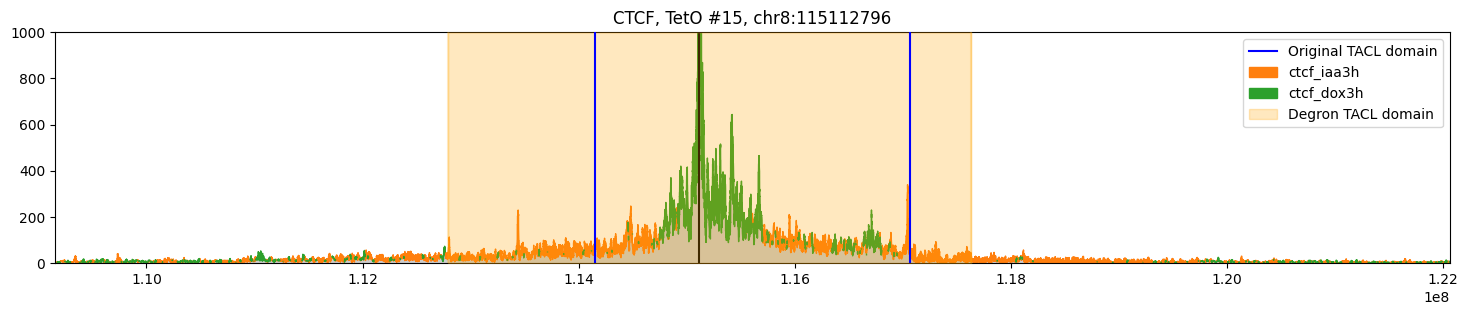

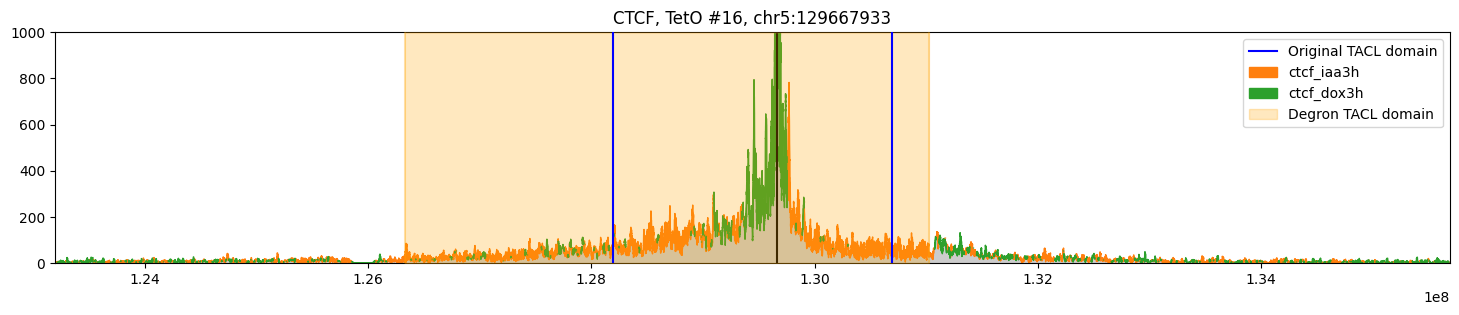

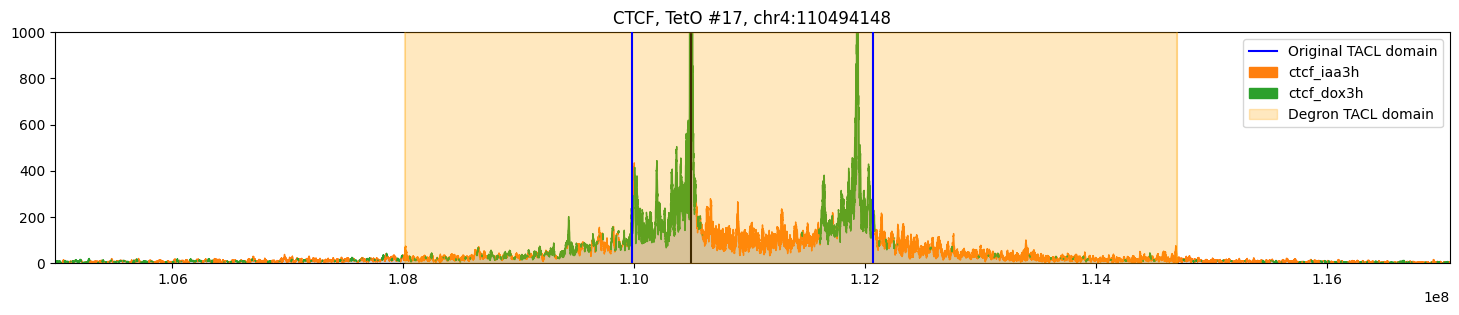

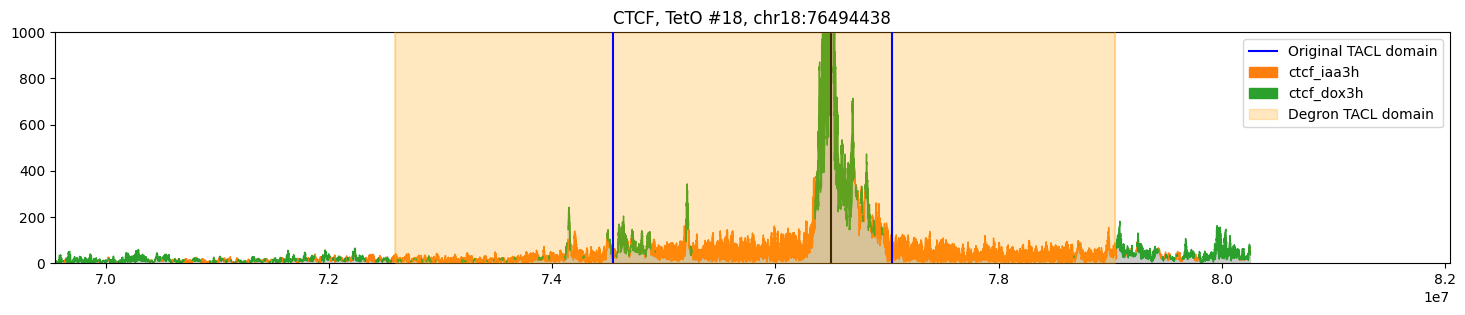

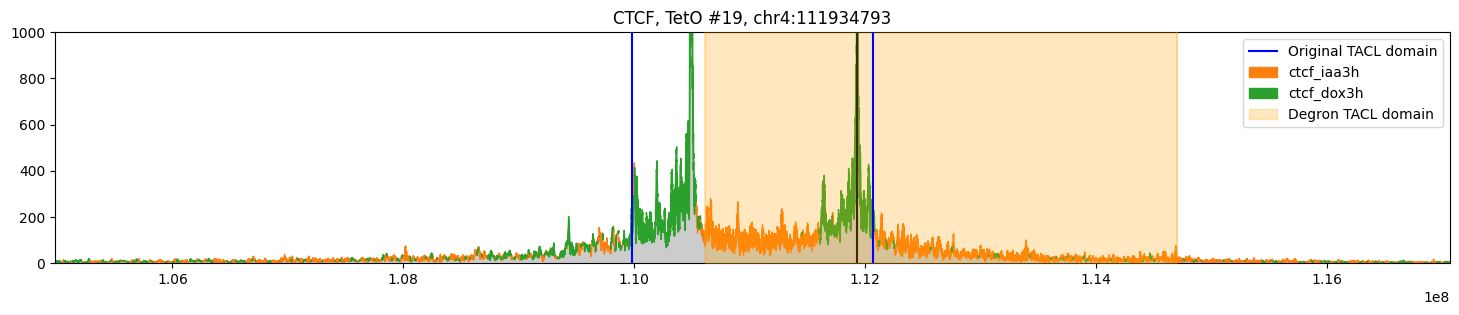

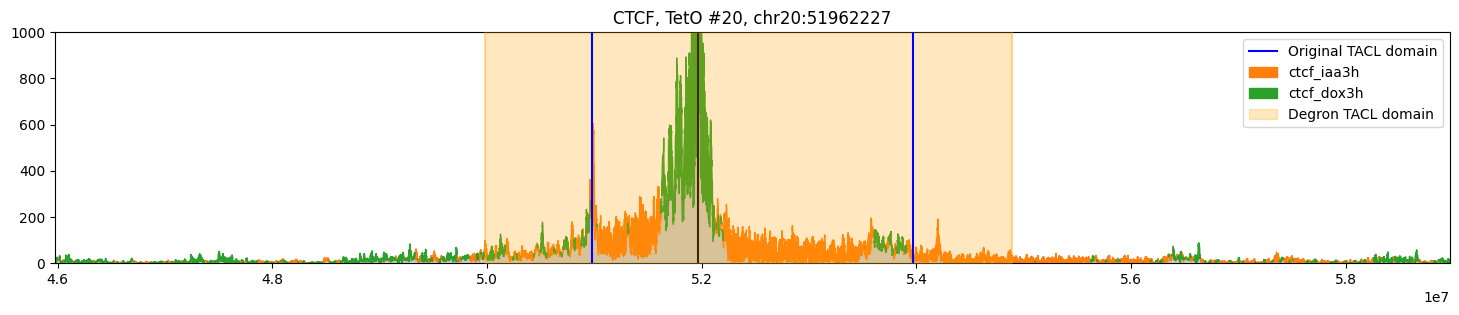

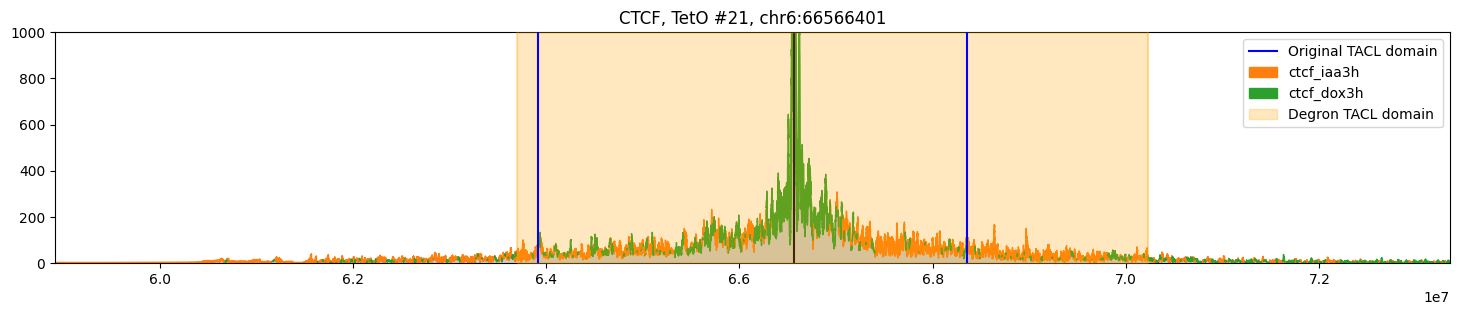

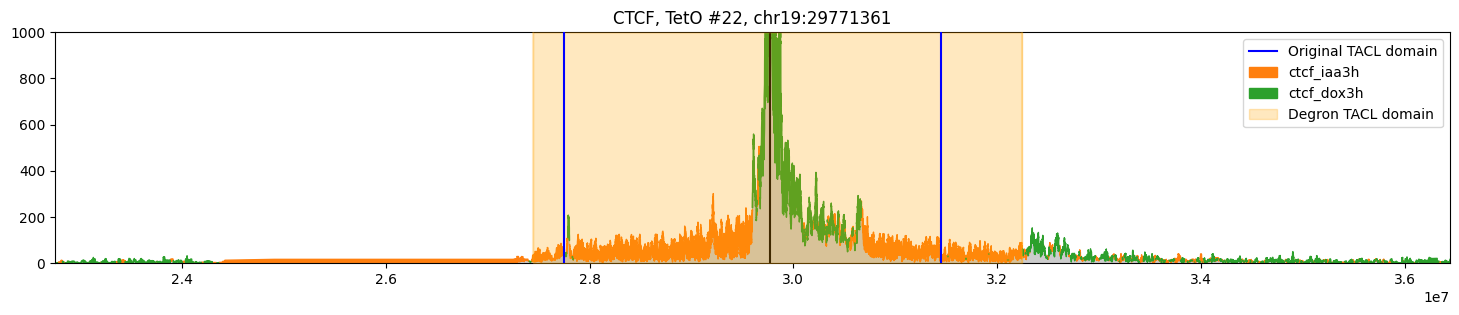

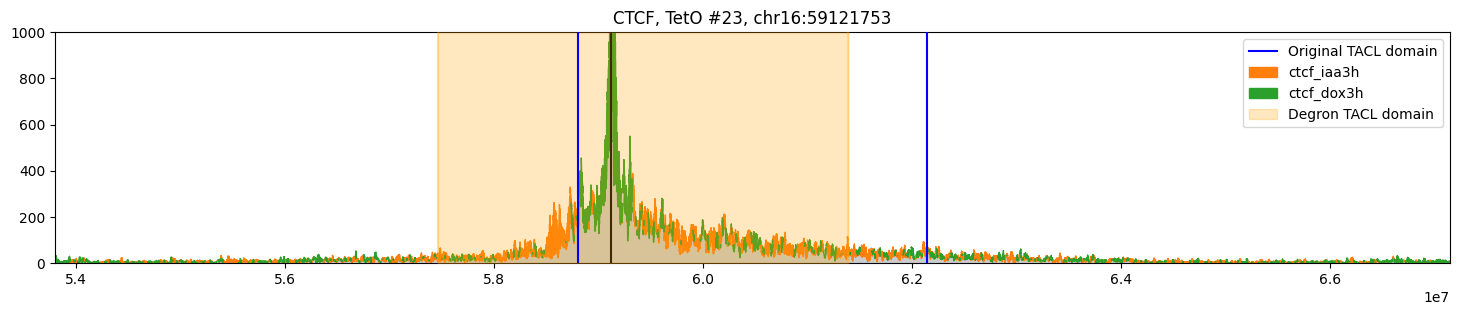

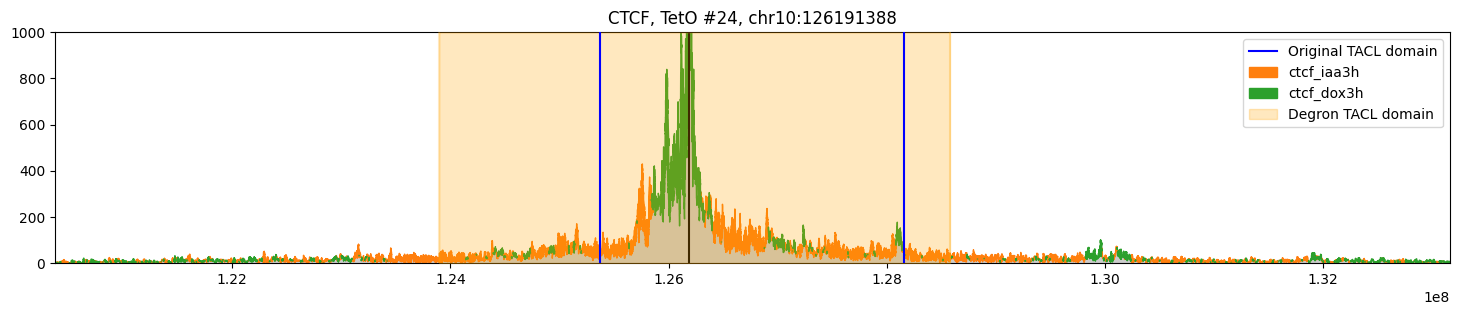

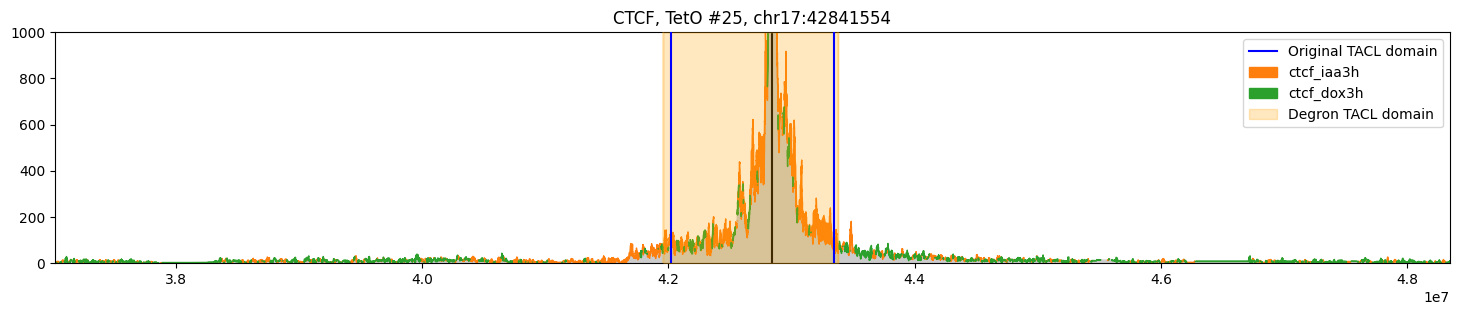

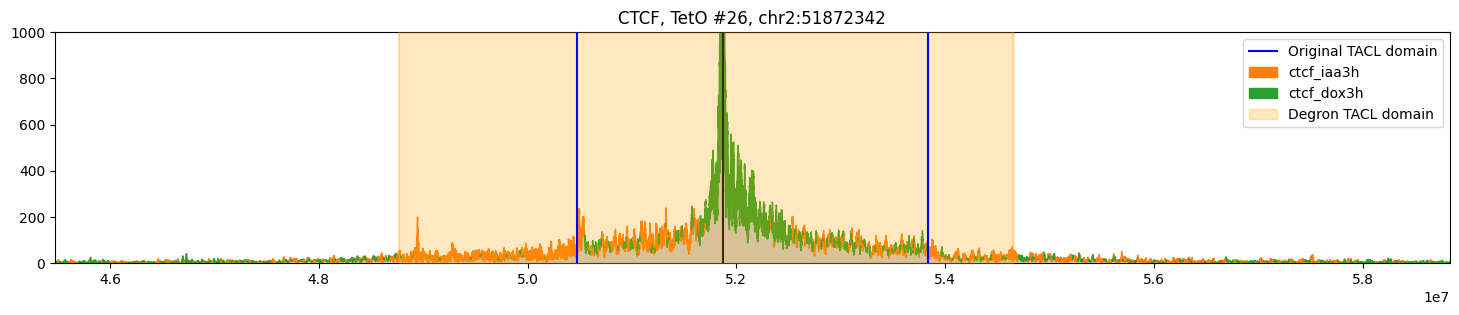

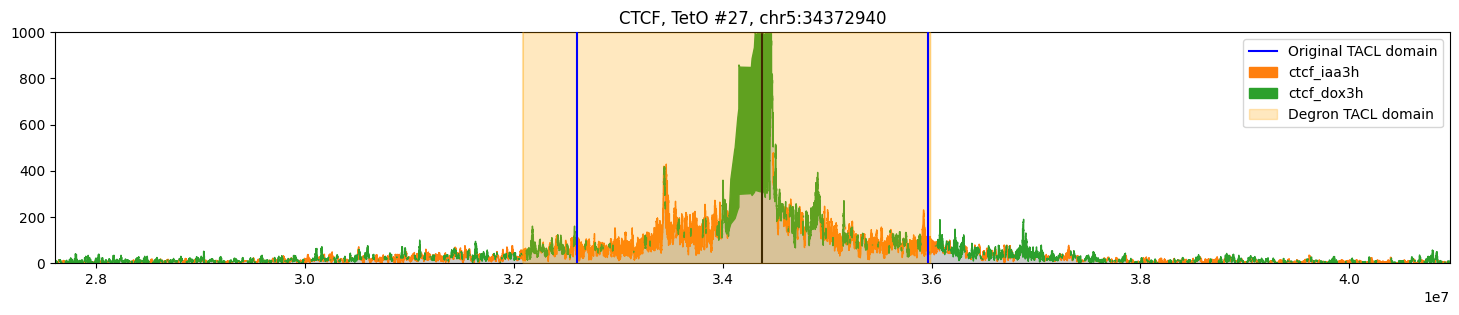

In [33]:
failed_viewpoints = []

for viewpoint_id_hmm in range(1, 28):
    if viewpoint_id_hmm not in failed_viewpoints:
        plot_tacl_domains(vp_data_merged, viewpoint_id_hmm, 'ctcf', 'ctcf_iaa3h', 'ctcf_dox3h', 'ctcf_unt', teto_coordinates, tacl_domains, 5000000)

#### PDS5A

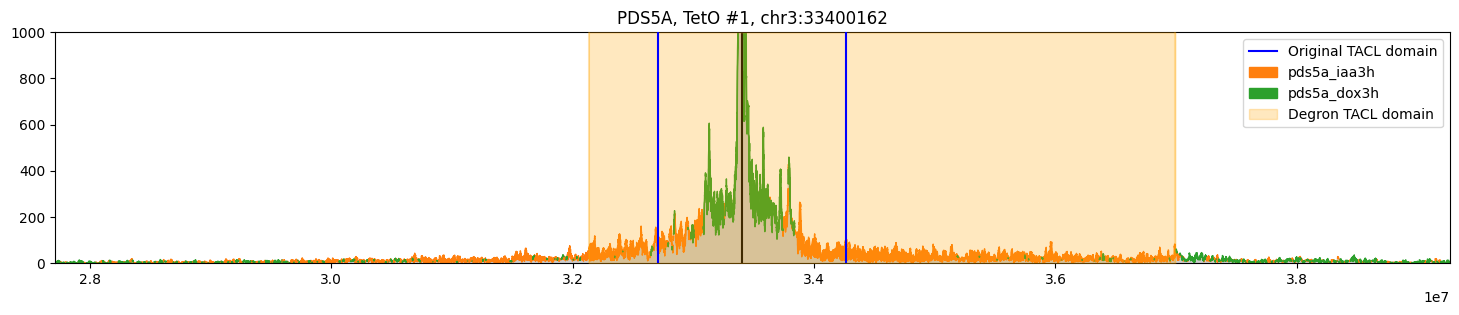

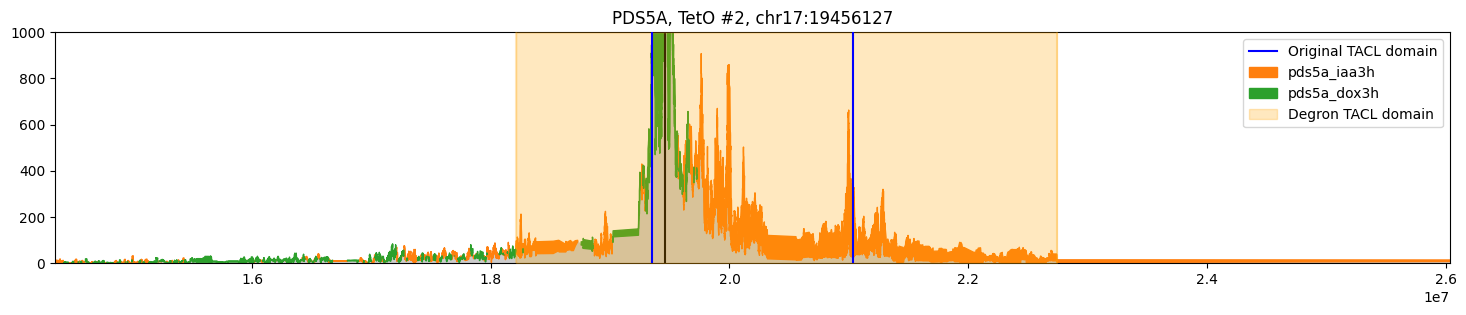

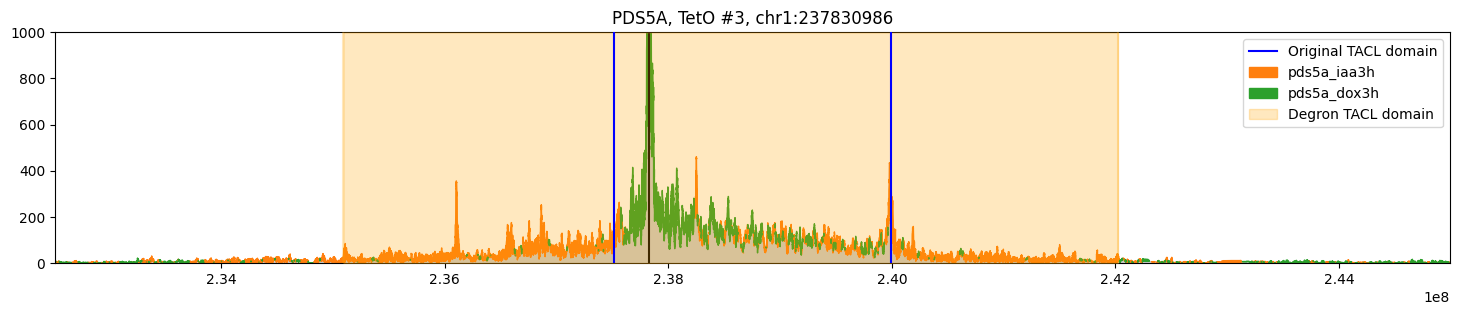

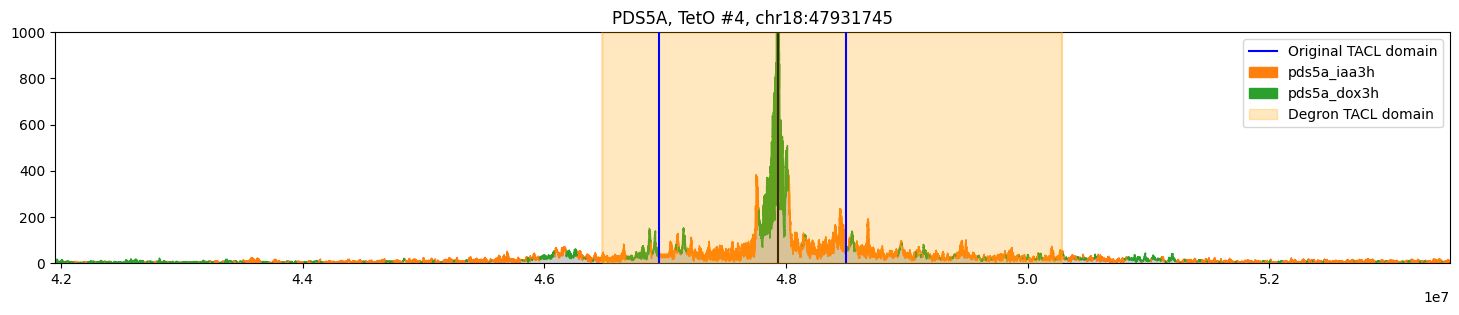

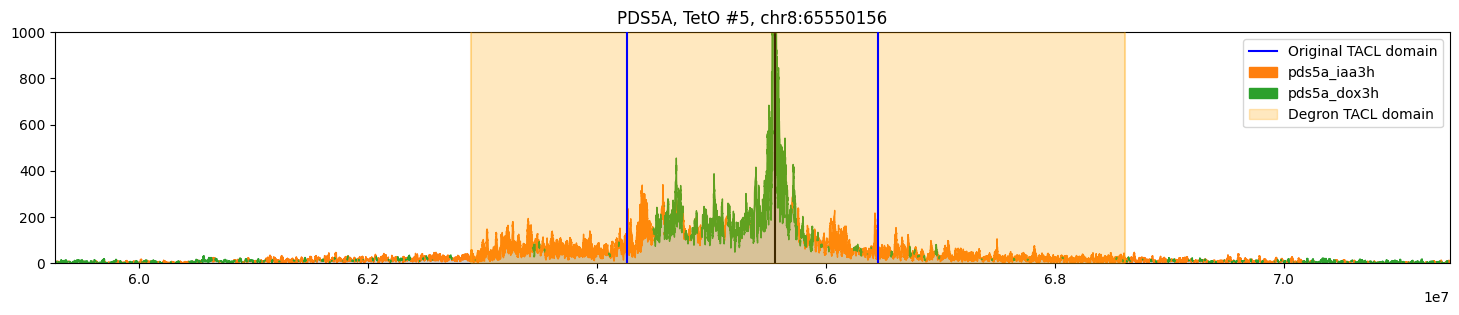

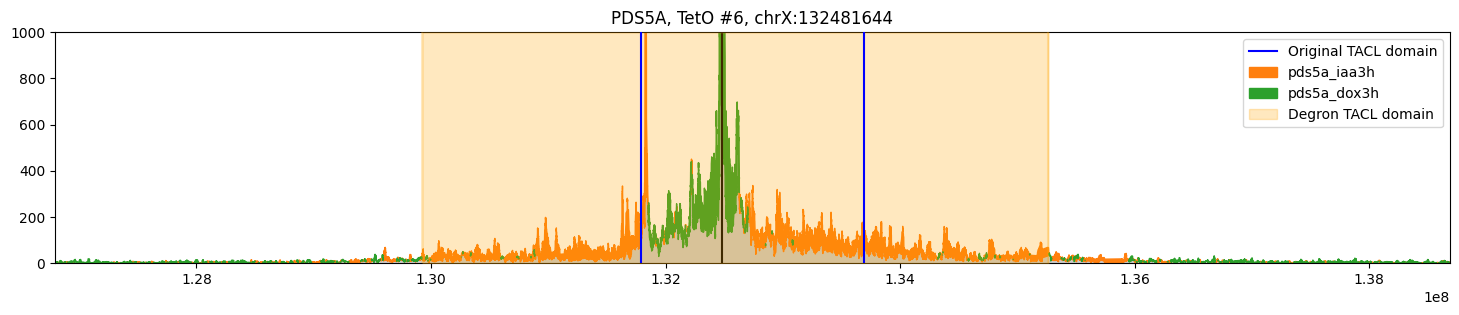

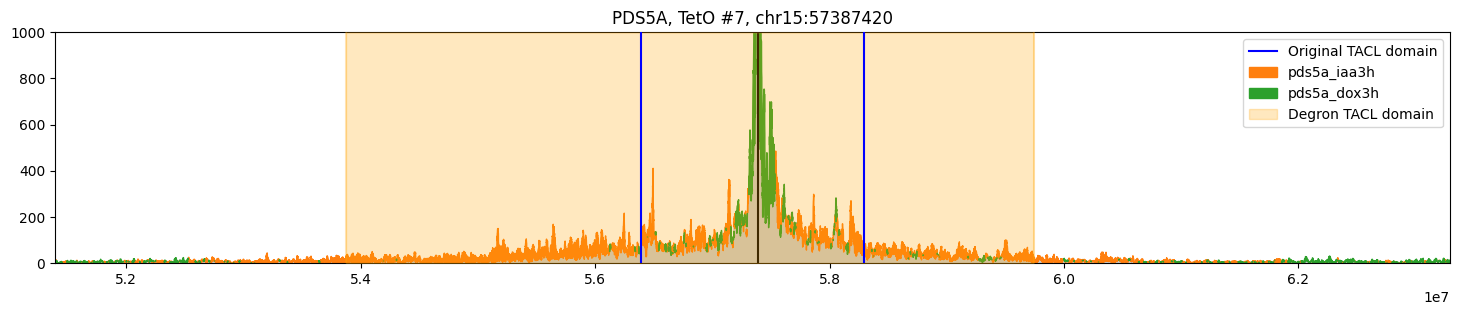

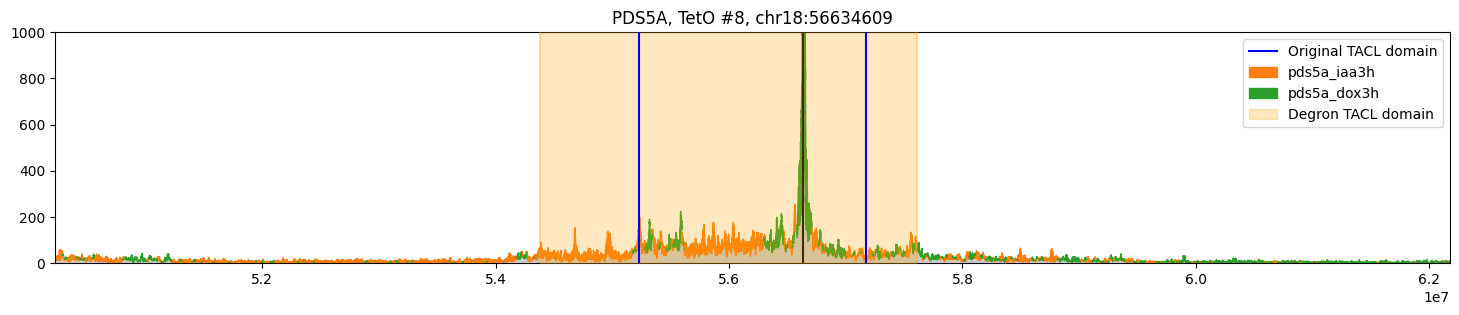

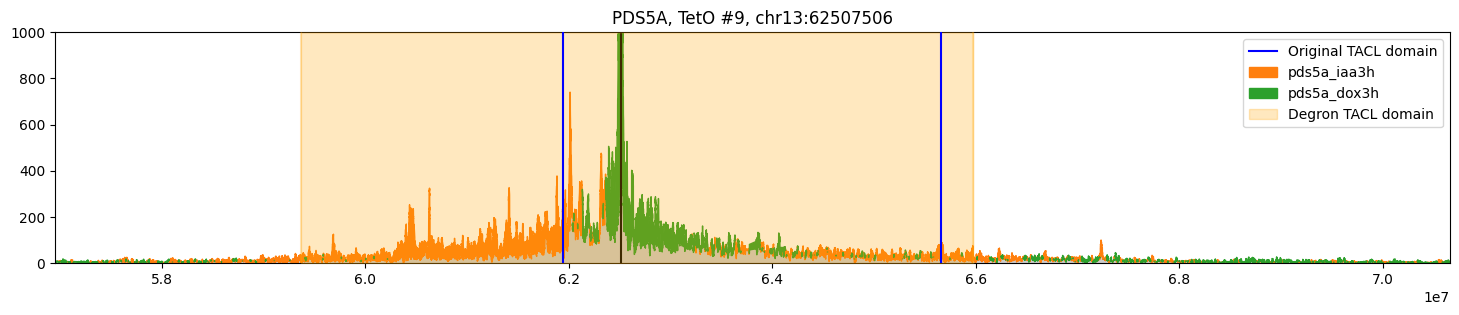

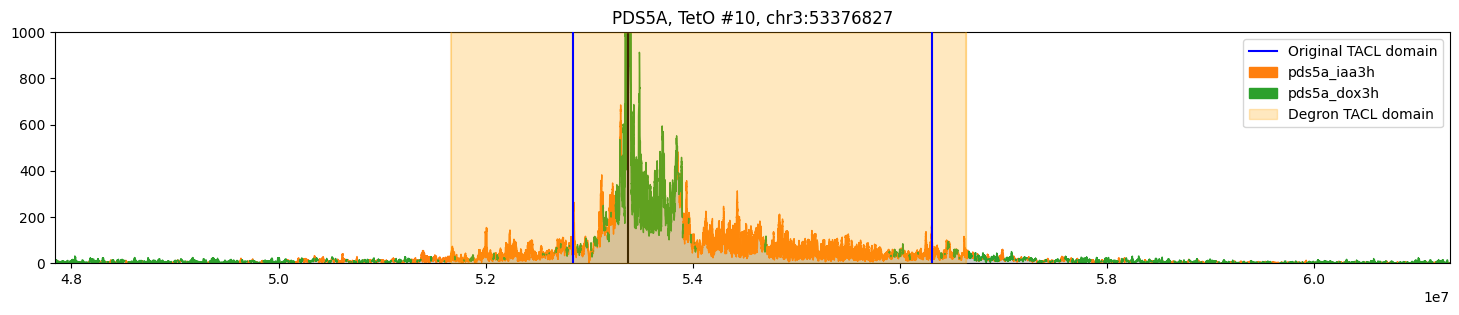

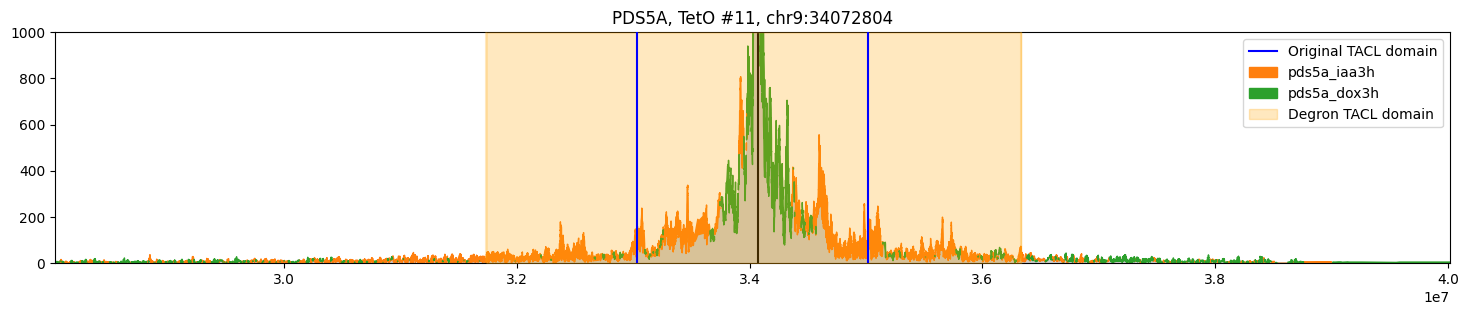

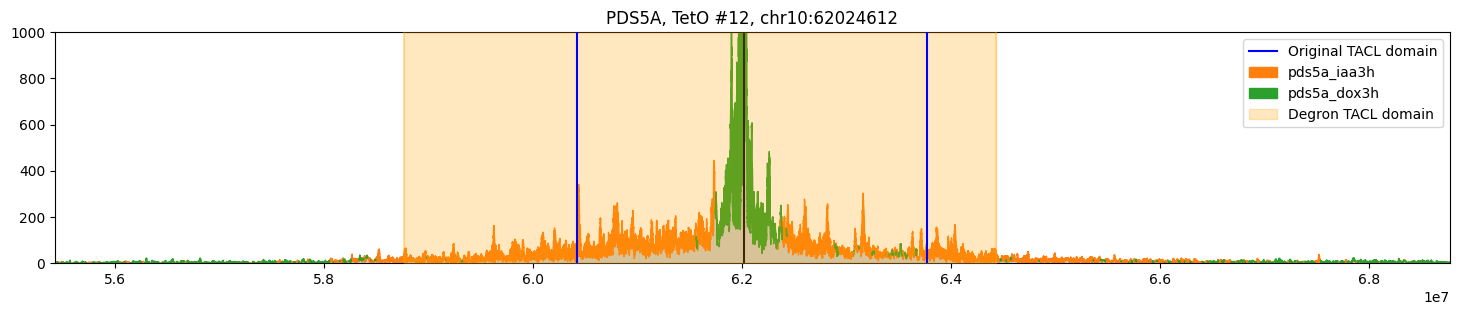

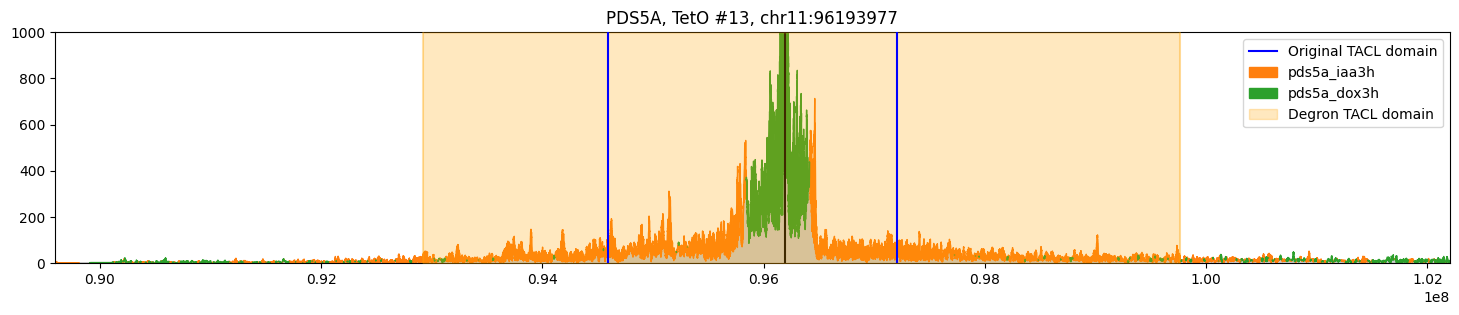

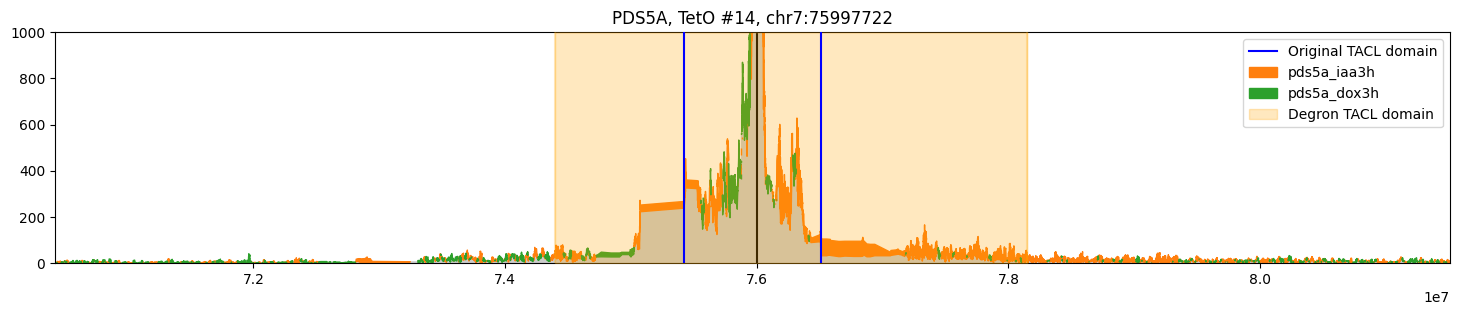

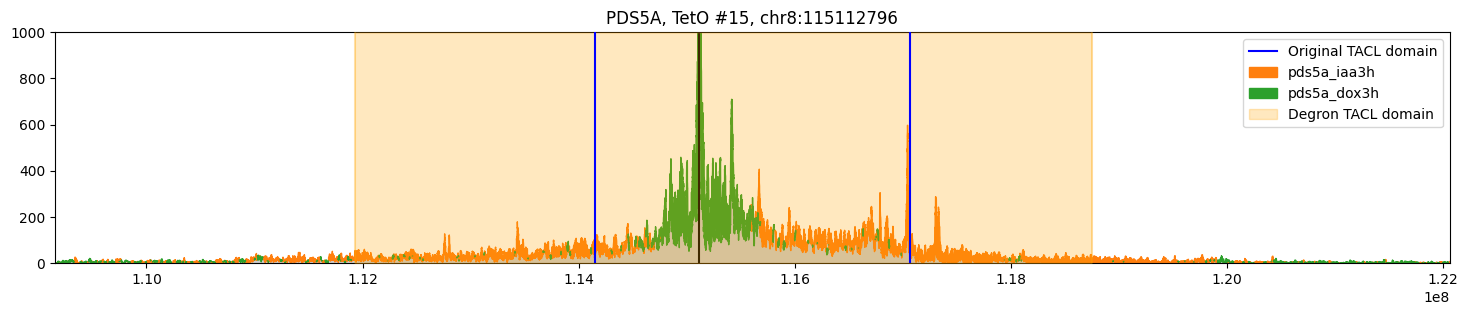

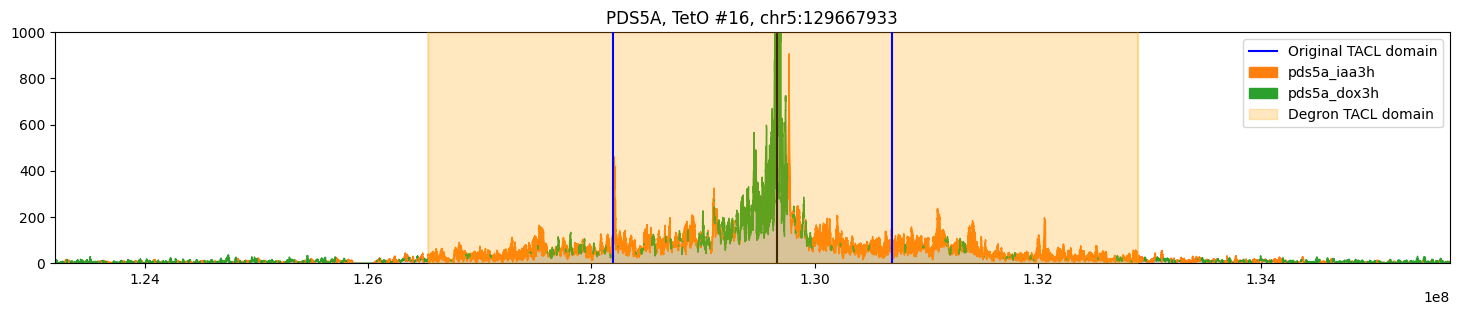

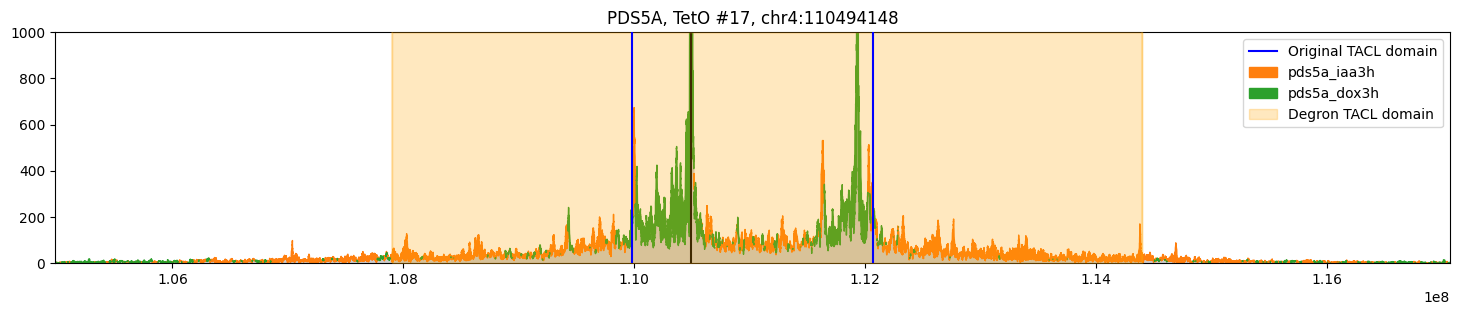

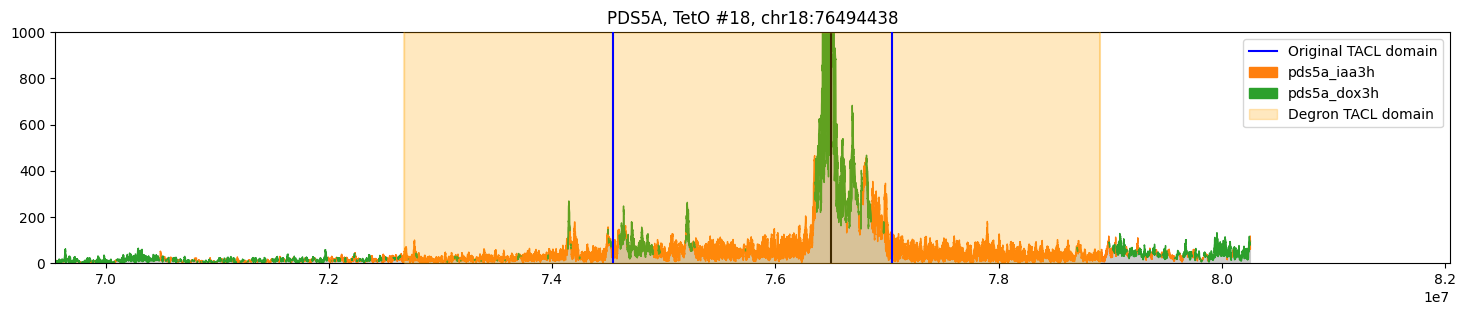

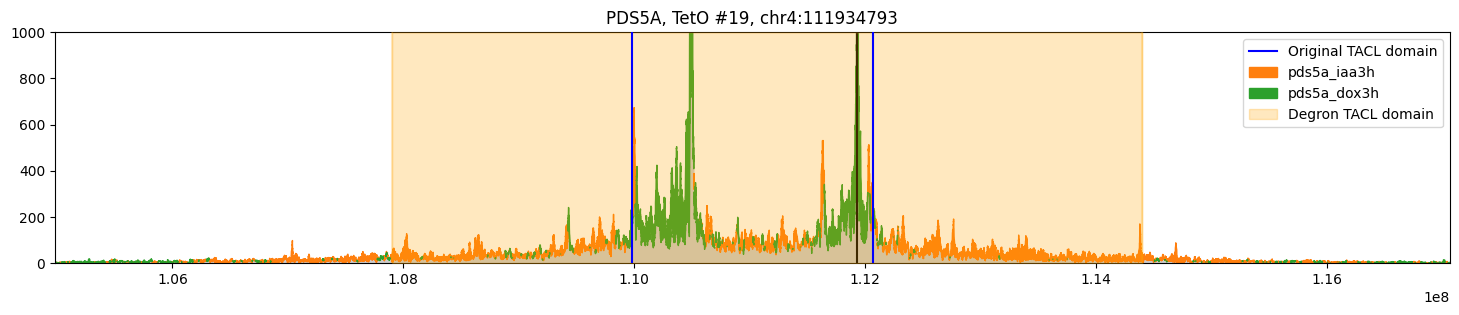

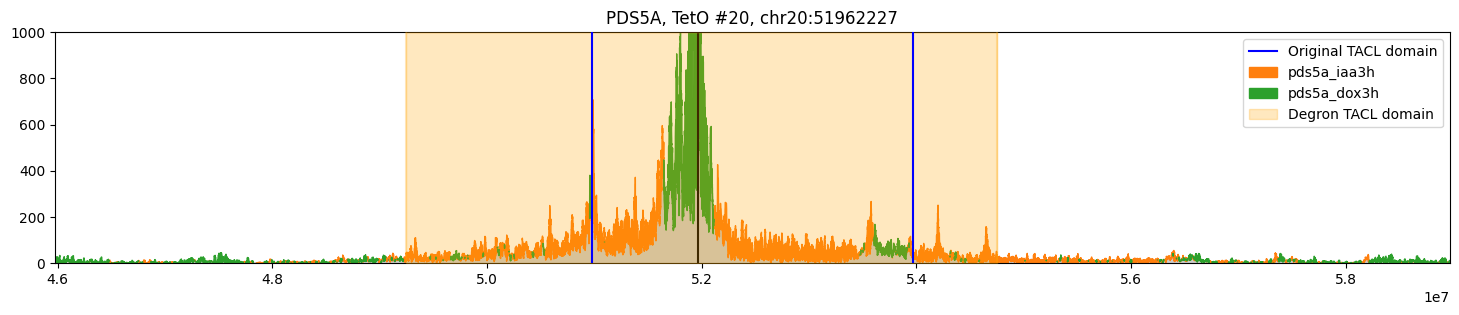

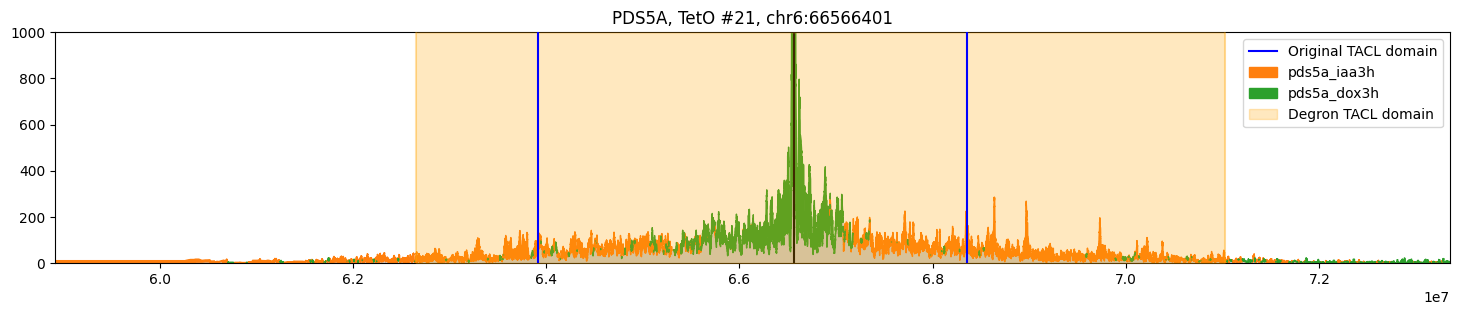

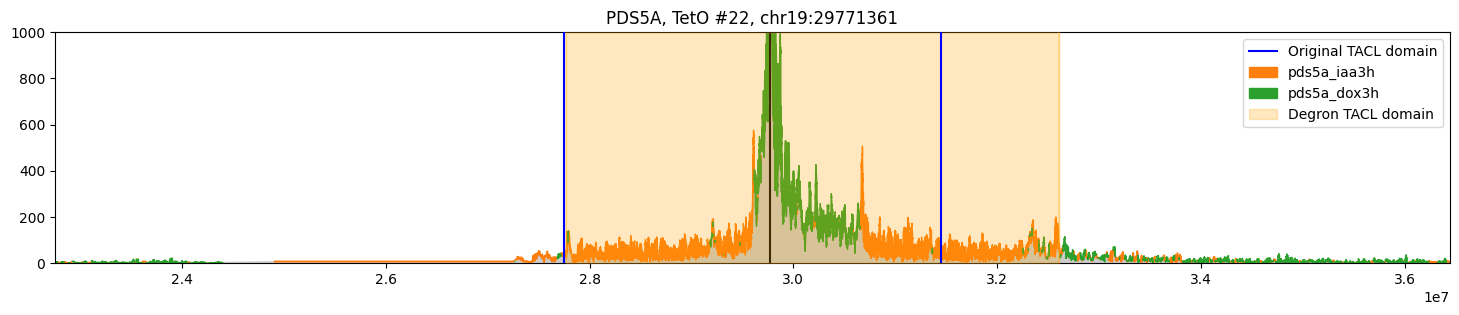

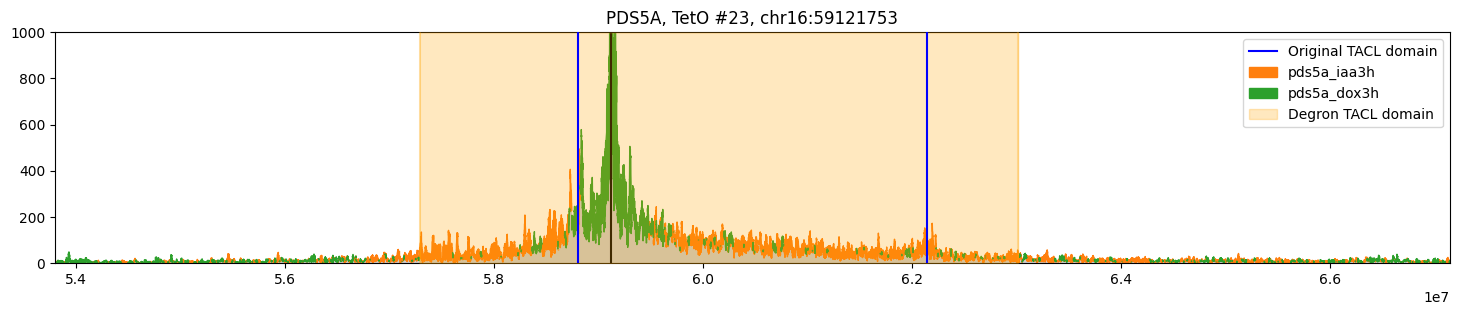

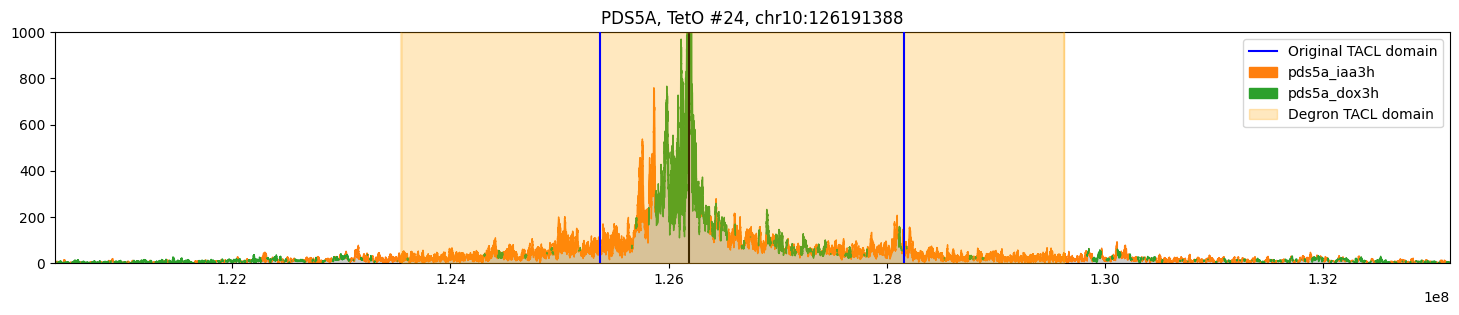

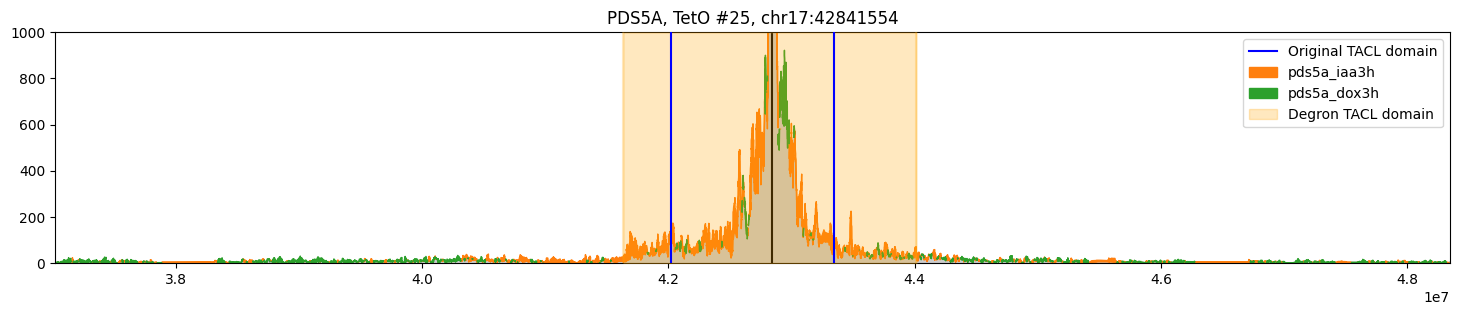

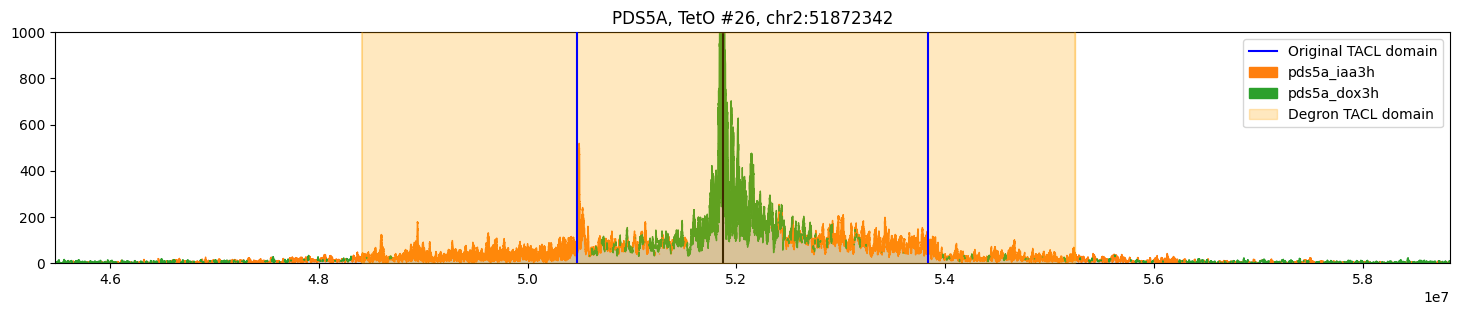

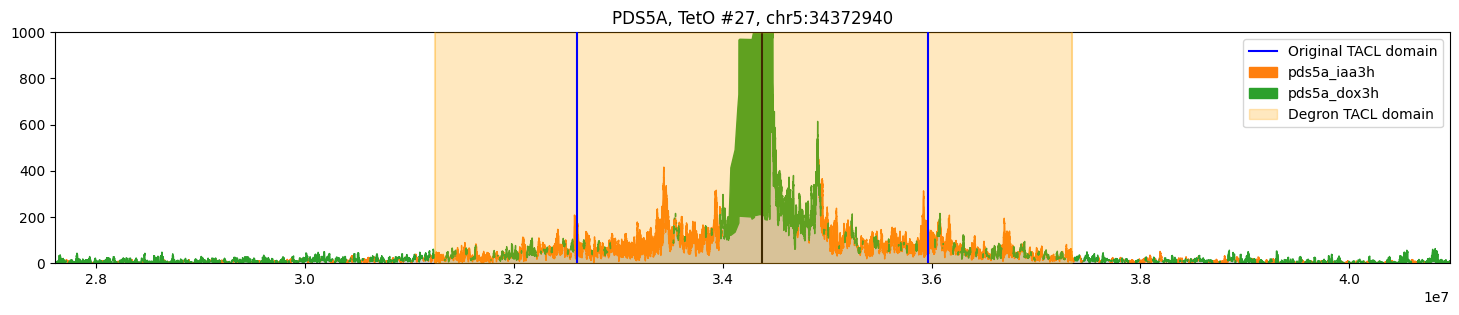

In [34]:
failed_viewpoints = []

for viewpoint_id_hmm in range(1, 28):
    if viewpoint_id_hmm not in failed_viewpoints:
        plot_tacl_domains(vp_data_merged, viewpoint_id_hmm, 'pds5a', 'pds5a_iaa3h', 'pds5a_dox3h', 'pds5a_unt', teto_coordinates, tacl_domains, 5000000)